# Optiver Trading at the Close EDA

---
## 1. Настройка и загрузка данных

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Настройки графиков
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Настройки отображения Pandas
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

In [93]:
dtypes = {
    'stock_id': 'int16',
    'date_id': 'int16',
    'seconds_in_bucket': 'int16',
    'imbalance_size': 'float32',
    'imbalance_buy_sell_flag': 'int8',
    'reference_price': 'float32',
    'matched_size': 'float32',
    'far_price': 'float32',
    'near_price': 'float32',
    'bid_price': 'float32',
    'bid_size': 'float32',
    'ask_price': 'float32',
    'ask_size': 'float32',
    'wap': 'float32',
    'target': 'float32',
    'time_id': 'int32',
}

df = pd.read_csv('../data/train.csv', dtype=dtypes)
print(f"Данные загружены: {df.shape[0]:,} строк, {df.shape[1]} столбцов")

Данные загружены: 5,237,980 строк, 17 столбцов


---
## 2. Краткий обзор данных

In [94]:
print(f"\nРазмер: {df.shape[0]:,} строк x {df.shape[1]} столбцов")
print(f"\nУникальных акций: {df['stock_id'].nunique()}")
print(f"Уникальных дат: {df['date_id'].nunique()}")
print(f"Уникальных временных корзин: {df['time_id'].nunique()}")
print(f"\nДиапазон секунд в корзине: {df['seconds_in_bucket'].min()} - {df['seconds_in_bucket'].max()}")
print(f"Уникальных значений секунд: {df['seconds_in_bucket'].nunique()}")


Размер: 5,237,980 строк x 17 столбцов

Уникальных акций: 200
Уникальных дат: 481
Уникальных временных корзин: 26455

Диапазон секунд в корзине: 0 - 540
Уникальных значений секунд: 55


In [95]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Кол-во пропусков': missing, 'Процент пропусков': missing_pct})

missing_df[missing_df['Кол-во пропусков'] > 0].sort_values('Процент пропусков', ascending=False)

,Кол-во пропусков,Процент пропусков
far_price,2894342,55.2600
near_price,2857180,54.5500
imbalance_size,220,0.0000
matched_size,220,0.0000
reference_price,220,0.0000
bid_price,220,0.0000
ask_price,220,0.0000
wap,220,0.0000
target,88,0.0000


In [96]:
df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5237980.0000,5237980.0000,5237980.0000,5237760.0000,5237980.0000,5237760.0000,5237760.0000,2343638.0000,2380800.0000,5237760.0000,5237980.0000,5237760.0000,5237980.0000,5237760.0000,5237892.0000,5237980.0000
mean,99.2886,241.5100,270.0000,5715293.0000,-0.0119,1.0000,45100244.0000,1.0017,0.9997,0.9997,51813.5859,1.0003,53575.6797,1.0000,-0.0476,13310.0521
std,57.8718,138.5319,158.7451,20515906.0000,0.8853,0.0025,139841296.0000,0.7215,0.0122,0.0025,111421.4062,0.0025,129355.4375,0.0025,9.4529,7619.2710
min,0.0000,0.0000,0.0000,0.0000,-1.0000,0.9353,4316.6099,0.0001,0.7870,0.9349,0.0000,0.9398,0.0000,0.9380,-385.2898,0.0000
25%,49.0000,122.0000,130.0000,84534.1484,-1.0000,0.9988,5279575.5000,0.9963,0.9971,0.9985,7374.7202,0.9990,7823.7002,0.9988,-4.5598,6729.0000
50%,99.0000,242.0000,270.0000,1113604.5000,0.0000,1.0000,12882638.0000,0.9999,0.9999,0.9997,21969.0000,1.0002,23017.9199,1.0000,-0.0602,13345.0000
75%,149.0000,361.0000,410.0000,4190951.0000,1.0000,1.0012,32700130.0000,1.0033,1.0026,1.0009,55831.6797,1.0014,57878.4092,1.0011,4.4096,19907.0000
max,199.0000,480.0000,540.0000,2982027776.0000,1.0000,1.0775,7713681920.0000,437.9531,1.3097,1.0775,30287840.0000,1.0778,54405000.0000,1.0777,446.0704,26454.0000


### 2.1 Типизация признаков

Классификация признаков по их семантическому типу для более глубокого анализа.


Идентификаторы: ['stock_id', 'date_id', 'time_id', 'row_id']
Временные: ['seconds_in_bucket']
Категориальные: ['imbalance_buy_sell_flag']
Ценовые: ['reference_price', 'far_price', 'near_price', 'bid_price', 'ask_price', 'wap']
Размер/объём: ['imbalance_size', 'matched_size', 'bid_size', 'ask_size']
Целевая: ['target']


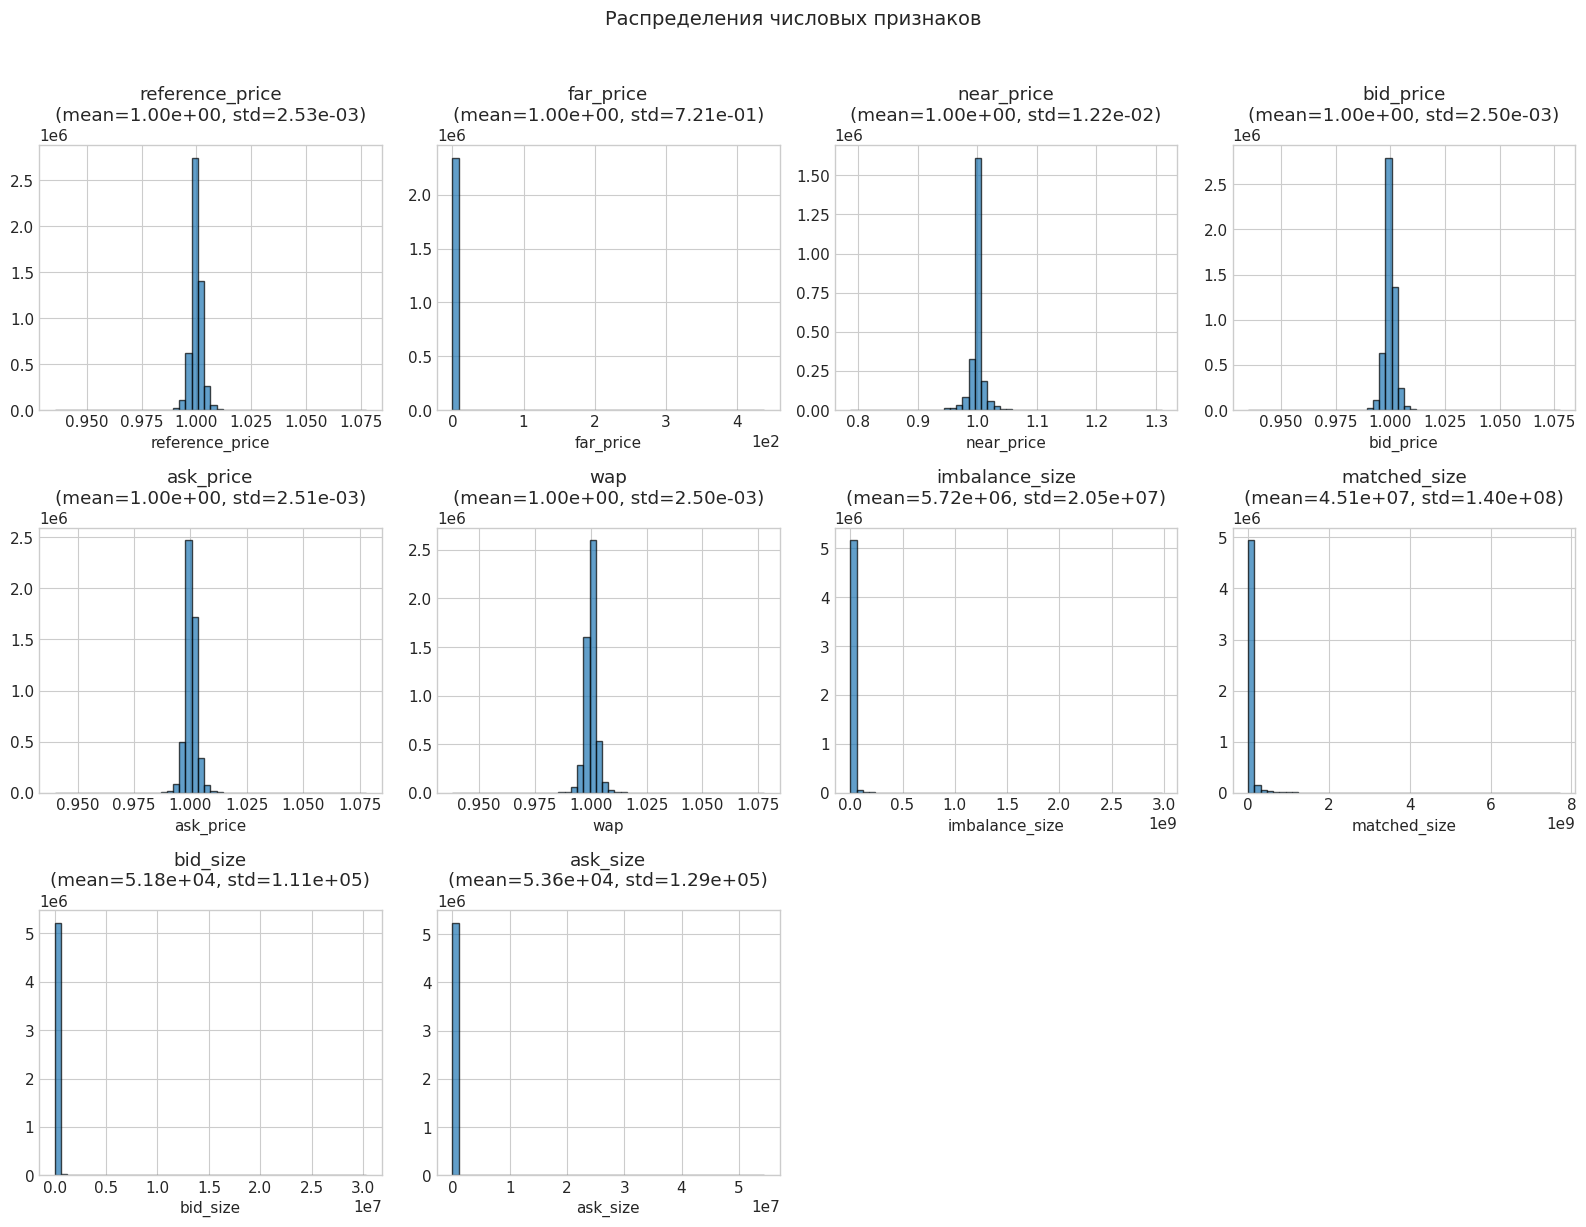


Распределение категориального признака (imbalance_buy_sell_flag):
imbalance_buy_sell_flag
-1    2084349
 0    1131594
 1    2022037
Name: count, dtype: int64


In [97]:
# Идентификаторы
id_features = ['stock_id', 'date_id', 'time_id', 'row_id']

# Временные признаки
temporal_features = ['seconds_in_bucket']

# Категориальные признаки
categorical_features = ['imbalance_buy_sell_flag']

# Ценовые признаки (нормализованные относительно WAP)
price_features = ['reference_price', 'far_price', 'near_price', 'bid_price', 'ask_price', 'wap']

# Признаки размера/объёма
size_features = ['imbalance_size', 'matched_size', 'bid_size', 'ask_size']

# Целевая переменная
target_feature = ['target']

print("\nИдентификаторы:", id_features)
print("Временные:", temporal_features)
print("Категориальные:", categorical_features)
print("Ценовые:", price_features)
print("Размер/объём:", size_features)
print("Целевая:", target_feature)

# Визуализация распределений числовых признаков
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

all_numeric = price_features + size_features
for i, feat in enumerate(all_numeric):
    if feat in df.columns and i < len(axes):
        data = df[feat].dropna()
        axes[i].hist(data, bins=50, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'{feat}\n(mean={data.mean():.2e}, std={data.std():.2e})')
        axes[i].set_xlabel(feat)
        axes[i].ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Скрыть лишние подграфики
for j in range(len(all_numeric), len(axes)):
    axes[j].axis('off')

plt.suptitle('Распределения числовых признаков', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Распределение категориального признака
print("\nРаспределение категориального признака (imbalance_buy_sell_flag):")
print(df['imbalance_buy_sell_flag'].value_counts().sort_index())

### 2.2 Выбросы

Систематический анализ выбросов в числовых признаках через IQR.

In [98]:
# Функция для выявления выбросов методом IQR
def detect_outliers_iqr(series, multiplier=1.5):
    """Выявление выбросов методом межквартильного размаха (IQR)"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers_mask = (series < lower_bound) | (series > upper_bound)
    return {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'n_outliers': outliers_mask.sum(),
        'pct_outliers': (outliers_mask.sum() / len(series.dropna())) * 100
    }

# Признаки для анализа (исключая ID)
outlier_features = ['imbalance_size', 'matched_size', 'bid_size', 'ask_size',
                    'reference_price', 'far_price', 'near_price', 'bid_price', 
                    'ask_price', 'wap', 'target']

outlier_results = []
for feat in outlier_features:
    if feat in df.columns:
        result = detect_outliers_iqr(df[feat].dropna())
        result['feature'] = feat
        outlier_results.append(result)

outlier_df = pd.DataFrame(outlier_results)
outlier_df = outlier_df[['feature', 'Q1', 'Q3', 'IQR', 'lower_bound', 'upper_bound', 'n_outliers', 'pct_outliers']]
outlier_df = outlier_df.sort_values('pct_outliers', ascending=False)

# Сводная таблица выбросов по признакам
outlier_df

,feature,Q1,Q3,IQR,lower_bound,upper_bound,n_outliers,pct_outliers
5,far_price,0.9963,1.0033,0.0070,0.9859,1.0138,501784,21.4105
6,near_price,0.9971,1.0026,0.0055,0.9889,1.0108,379225,15.9285
1,matched_size,5279575.3750,32700130.0000,27420554.6250,-35851256.5625,73830961.9375,637237,12.1662
0,imbalance_size,84534.1504,4190951.0000,4106416.8496,-6075091.1240,10350576.2744,619374,11.8252
2,bid_size,7374.7202,55831.6797,48456.9595,-65310.7190,128517.1189,509948,9.7356
3,ask_size,7823.7002,57878.4092,50054.7090,-67258.3633,132960.4727,505021,9.6415
9,wap,0.9988,1.0011,0.0024,0.9952,1.0047,325523,6.2149
7,bid_price,0.9985,1.0009,0.0024,0.9950,1.0045,323878,6.1835
8,ask_price,0.9990,1.0014,0.0024,0.9955,1.0050,321691,6.1418
4,reference_price,0.9988,1.0012,0.0024,0.9951,1.0048,320803,6.1248


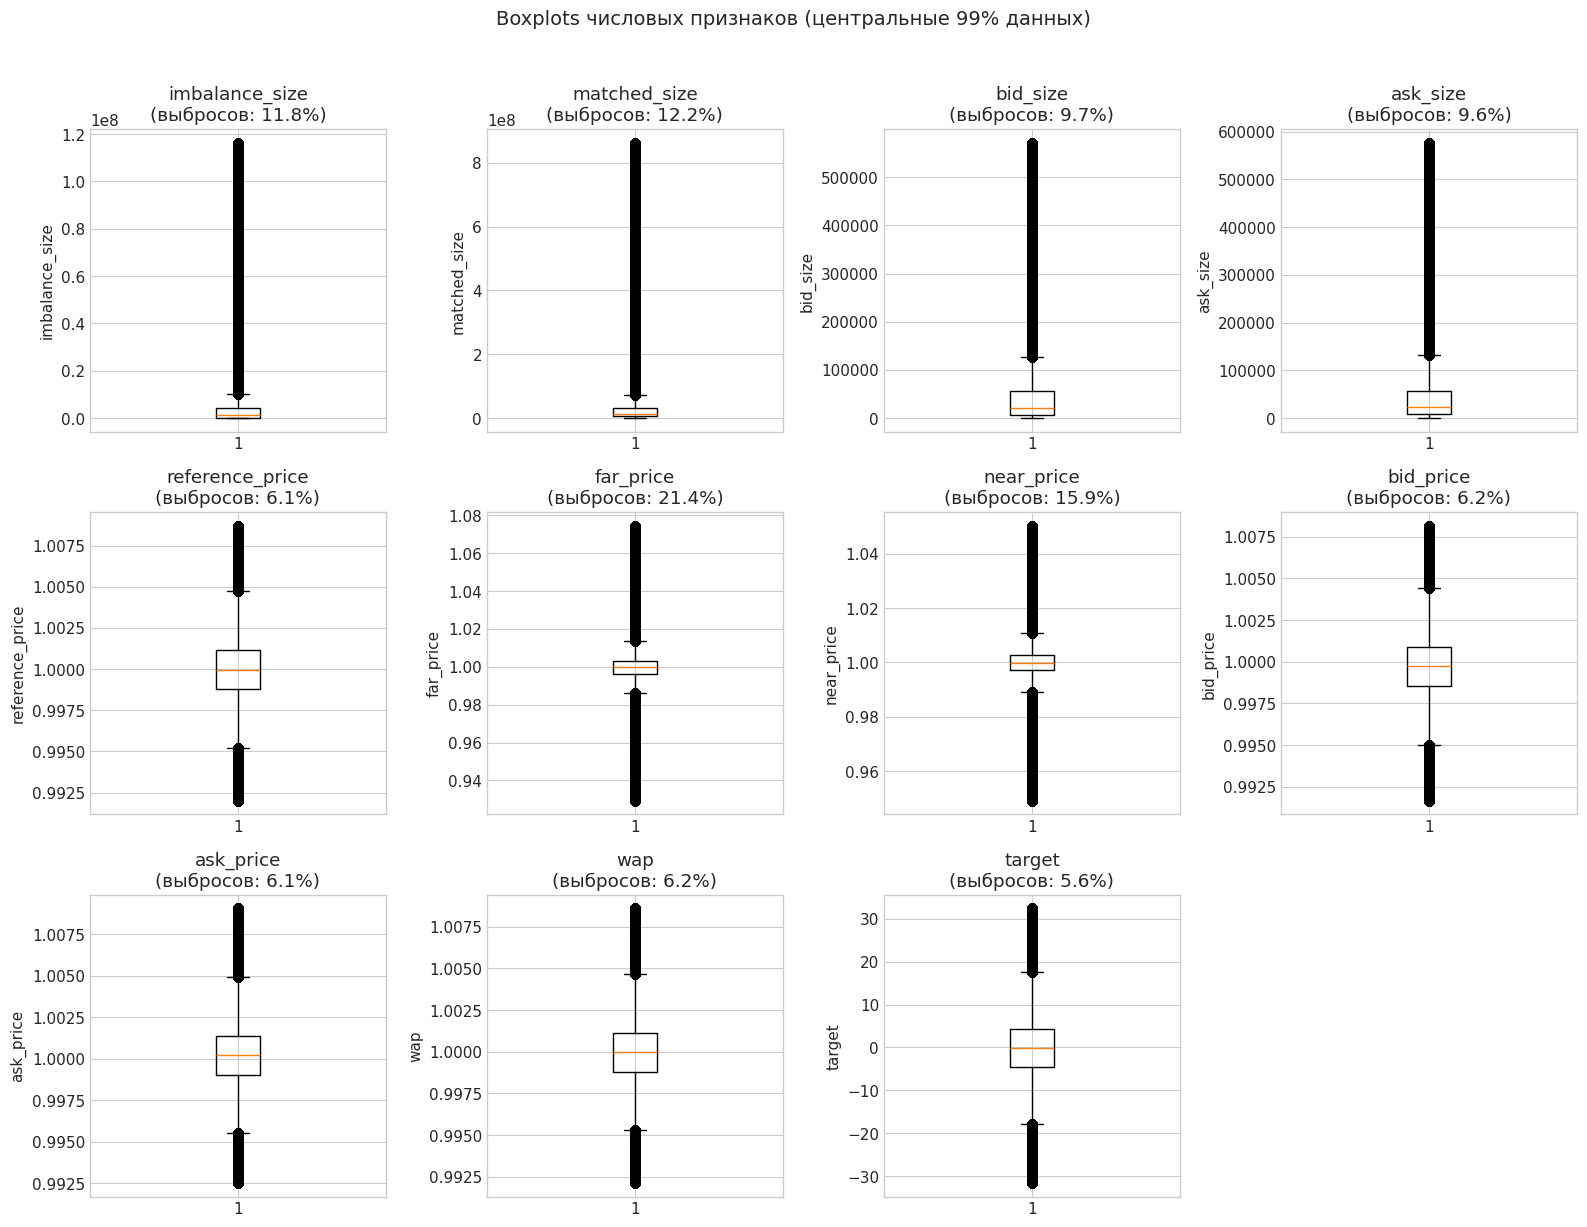

In [99]:
# Визуализация: boxplots для всех признаков
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, feat in enumerate(outlier_features):
    if feat in df.columns and i < len(axes):
        data = df[feat].dropna()
        # Для очень скошенных распределений показываем только центральные 99%
        q_low, q_high = data.quantile([0.005, 0.995])
        filtered_data = data[(data >= q_low) & (data <= q_high)]
        
        axes[i].boxplot(filtered_data, vert=True)
        axes[i].set_title(f'{feat}\n(выбросов: {outlier_df[outlier_df["feature"]==feat]["pct_outliers"].values[0]:.1f}%)')
        axes[i].set_ylabel(feat)

# Скрыть лишние подграфики
for j in range(len(outlier_features), len(axes)):
    axes[j].axis('off')

plt.suptitle('Boxplots числовых признаков (центральные 99% данных)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

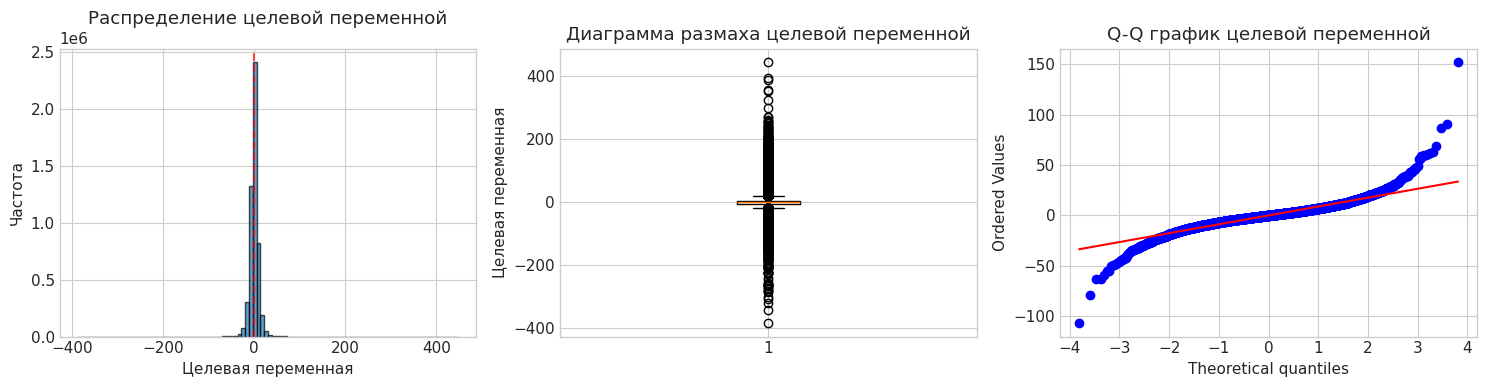


Статистика целевой переменной:
Среднее: -0.0476
Медиана: -0.0602
Станд. отклонение: 9.4529
Асимметрия: 0.2047
Эксцесс: 22.5580
Минимум: -385.2898
Максимум: 446.0704


In [100]:
# Распределение целевой переменной
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Гистограмма
axes[0].hist(df['target'].dropna(), bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Целевая переменная')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение целевой переменной')
axes[0].axvline(x=0, color='r', linestyle='--', alpha=0.7)

# Ящик с усами
axes[1].boxplot(df['target'].dropna(), vert=True)
axes[1].set_ylabel('Целевая переменная')
axes[1].set_title('Диаграмма размаха целевой переменной')

# Q-Q график
stats.probplot(df['target'].dropna().sample(10000), dist="norm", plot=axes[2])
axes[2].set_title('Q-Q график целевой переменной')

plt.tight_layout()
plt.show()

# Статистика целевой переменной
print("\nСтатистика целевой переменной:")
print(f"Среднее: {df['target'].mean():.4f}")
print(f"Медиана: {df['target'].median():.4f}")
print(f"Станд. отклонение: {df['target'].std():.4f}")
print(f"Асимметрия: {df['target'].skew():.4f}")
print(f"Эксцесс: {df['target'].kurtosis():.4f}")
print(f"Минимум: {df['target'].min():.4f}")
print(f"Максимум: {df['target'].max():.4f}")

---
## 3. Анализ временной структуры (ОСНОВНОЙ ФОКУС)

### 3.1 Распределение в окне аукциона

In [101]:
# Количество наблюдений по seconds_in_bucket
seconds_counts = df['seconds_in_bucket'].value_counts().sort_index()

fig = px.bar(
    x=seconds_counts.index,
    y=seconds_counts.values,
    labels={'x': 'Секунды в корзине', 'y': 'Количество наблюдений'},
    title='Распределение наблюдений в течение окна аукциона'
)
fig.update_layout(height=400)
fig.show()

print(f"\nУникальных значений секунд: {len(seconds_counts)}")
print(f"Наиболее частая секунда: {seconds_counts.idxmax()} с {seconds_counts.max():,} наблюдениями")
print(f"Наименее частая секунда: {seconds_counts.idxmin()} с {seconds_counts.min():,} наблюдениями")


Уникальных значений секунд: 55
Наиболее частая секунда: 0 с 95,236 наблюдениями
Наименее частая секунда: 0 с 95,236 наблюдениями


### 3.2 Эволюция признаков внутри аукциона

In [102]:
# Ключевые признаки для анализа в течение окна аукциона
features = ['imbalance_size', 'matched_size', 'bid_size', 'ask_size', 
            'reference_price', 'wap', 'bid_price', 'ask_price']

# Агрегация по seconds_in_bucket
temporal_agg = df.groupby('seconds_in_bucket')[features].agg(['mean', 'median', 'std'])

# График средних значений признаков, связанных с размером
size_features = ['imbalance_size', 'matched_size', 'bid_size', 'ask_size']

fig = make_subplots(rows=2, cols=2, subplot_titles=['Размер дисбаланса', 'Объём сопоставленных заявок', 'Размер заявок bid', 'Размер заявок ask'])

for i, feat in enumerate(size_features):
    row = i // 2 + 1
    col = i % 2 + 1
    fig.add_trace(
        go.Scatter(
            x=temporal_agg.index,
            y=temporal_agg[(feat, 'mean')],
            mode='lines',
            name=f'{feat} (среднее)'
        ),
        row=row, col=col
    )

fig.update_layout(height=600, title_text='Эволюция признаков размера во время аукциона', showlegend=False)
fig.show()

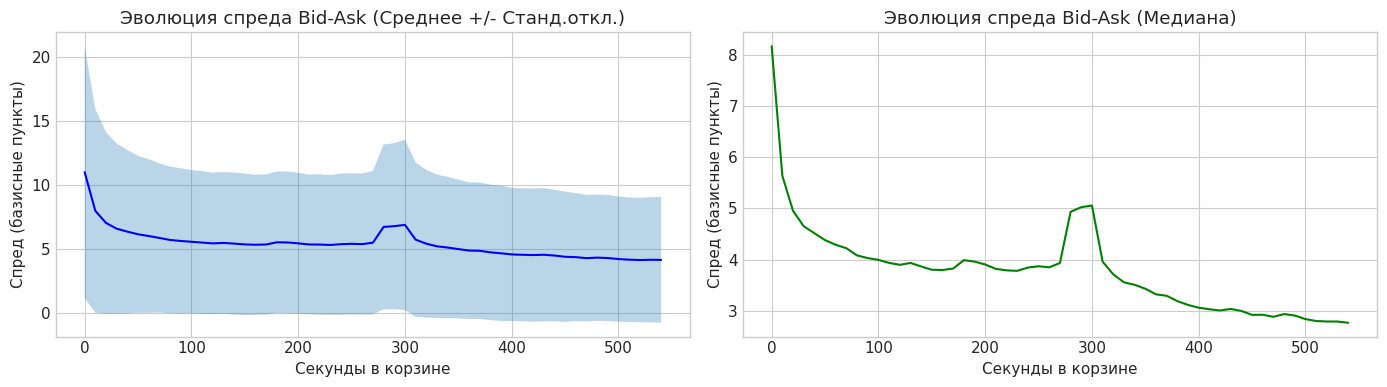

In [103]:
# Эволюция спреда Bid-Ask
df['spread'] = df['ask_price'] - df['bid_price']
df['spread_pct'] = df['spread'] / df['wap'] * 10000  # в базисных пунктах

spread_by_time = df.groupby('seconds_in_bucket')['spread_pct'].agg(['mean', 'median', 'std'])

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Средний спред
axes[0].plot(spread_by_time.index, spread_by_time['mean'], label='Среднее', color='blue')
axes[0].fill_between(
    spread_by_time.index,
    spread_by_time['mean'] - spread_by_time['std'],
    spread_by_time['mean'] + spread_by_time['std'],
    alpha=0.3
)
axes[0].set_xlabel('Секунды в корзине')
axes[0].set_ylabel('Спред (базисные пункты)')
axes[0].set_title('Эволюция спреда Bid-Ask (Среднее +/- Станд.откл.)')

# Медианный спред
axes[1].plot(spread_by_time.index, spread_by_time['median'], color='green')
axes[1].set_xlabel('Секунды в корзине')
axes[1].set_ylabel('Спред (базисные пункты)')
axes[1].set_title('Эволюция спреда Bid-Ask (Медиана)')

plt.tight_layout()
plt.show()

In [104]:
# Эволюция размера дисбаланса с доверительными интервалами
imbalance_by_time = df.groupby('seconds_in_bucket')['imbalance_size'].agg(['mean', 'median', 'std', 'count'])
imbalance_by_time['sem'] = imbalance_by_time['std'] / np.sqrt(imbalance_by_time['count'])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=imbalance_by_time.index,
    y=imbalance_by_time['mean'],
    mode='lines',
    name='Среднее',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=imbalance_by_time.index,
    y=imbalance_by_time['median'],
    mode='lines',
    name='Медиана',
    line=dict(color='green', dash='dash')
))

fig.update_layout(
    title='Эволюция размера дисбаланса во время аукциона',
    xaxis_title='Секунды в корзине',
    yaxis_title='Размер дисбаланса ($)',
    height=400
)
fig.show()

In [105]:
# Рост объёма сопоставленных заявок во время аукциона
matched_by_time = df.groupby('seconds_in_bucket')['matched_size'].agg(['mean', 'median'])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=matched_by_time.index,
    y=matched_by_time['mean'],
    mode='lines',
    name='Среднее',
    fill='tozeroy'
))

fig.update_layout(
    title='Рост объёма сопоставленных заявок во время аукциона',
    xaxis_title='Секунды в корзине',
    yaxis_title='Объём сопоставленных заявок ($)',
    height=400
)
fig.show()

### 3.3 Временные паттерны целевой переменной

In [106]:
# Статистика целевой переменной по seconds_in_bucket
target_by_time = df.groupby('seconds_in_bucket')['target'].agg(['mean', 'median', 'std', 'count'])

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Среднее целевой переменной', 'Станд.откл. целевой (Волатильность)', 'Медиана целевой переменной', 'Количество наблюдений']
)

# Среднее
fig.add_trace(
    go.Scatter(x=target_by_time.index, y=target_by_time['mean'], mode='lines', name='Среднее'),
    row=1, col=1
)
fig.add_hline(y=0, line_dash='dash', line_color='red', row=1, col=1)

# Станд.откл.
fig.add_trace(
    go.Scatter(x=target_by_time.index, y=target_by_time['std'], mode='lines', name='Станд.откл.', line=dict(color='orange')),
    row=1, col=2
)

# Медиана
fig.add_trace(
    go.Scatter(x=target_by_time.index, y=target_by_time['median'], mode='lines', name='Медиана', line=dict(color='green')),
    row=2, col=1
)
fig.add_hline(y=0, line_dash='dash', line_color='red', row=2, col=1)

# Количество
fig.add_trace(
    go.Bar(x=target_by_time.index, y=target_by_time['count'], name='Количество'),
    row=2, col=2
)

fig.update_layout(height=600, title_text='Статистика целевой переменной в течение окна аукциона', showlegend=False)
fig.show()

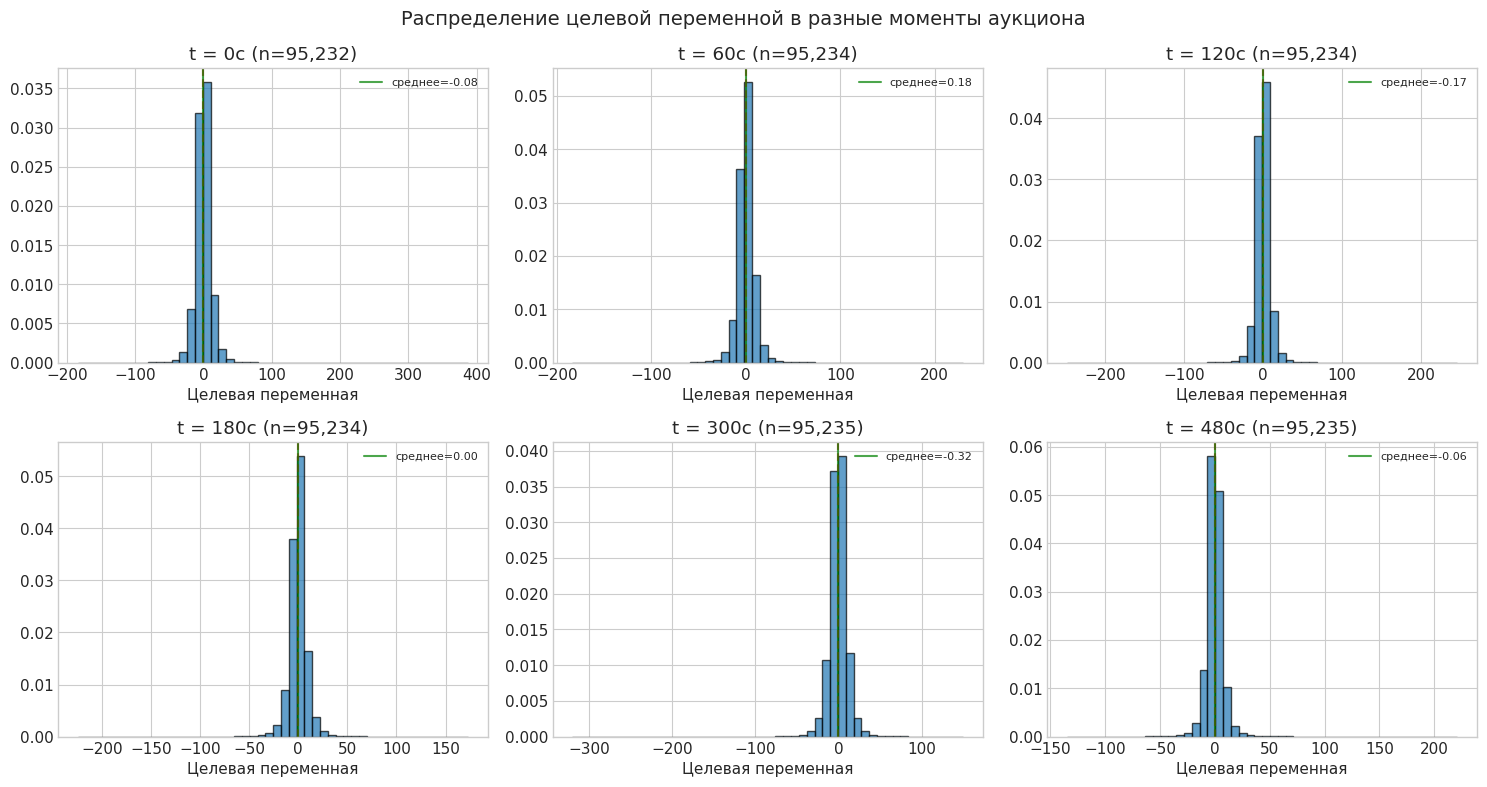

In [107]:
# Распределение целевой переменной в разные моменты аукциона
time_points = [0, 60, 120, 180, 300, 480]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, t in enumerate(time_points):
    data = df[df['seconds_in_bucket'] == t]['target'].dropna()
    axes[i].hist(data, bins=50, edgecolor='black', alpha=0.7, density=True)
    axes[i].set_title(f't = {t}с (n={len(data):,})')
    axes[i].set_xlabel('Целевая переменная')
    axes[i].axvline(x=0, color='r', linestyle='--', alpha=0.7)
    axes[i].axvline(x=data.mean(), color='g', linestyle='-', alpha=0.7, label=f'среднее={data.mean():.2f}')
    axes[i].legend(fontsize=8)

plt.suptitle('Распределение целевой переменной в разные моменты аукциона', fontsize=14)
plt.tight_layout()
plt.show()

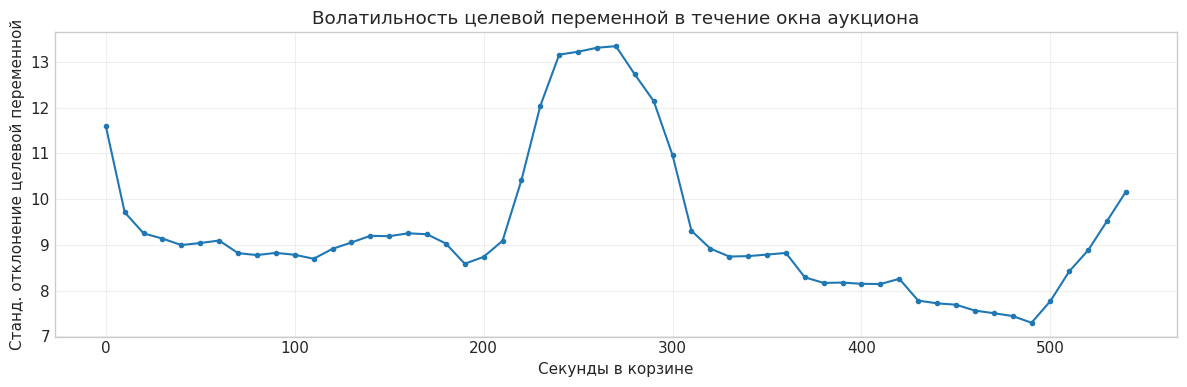

In [108]:
# Расчёт коэффициента вариации
target_by_time['cv'] = target_by_time['std'] / np.abs(target_by_time['mean'].replace(0, np.nan))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(target_by_time.index, target_by_time['std'], marker='o', markersize=3)
ax.set_xlabel('Секунды в корзине')
ax.set_ylabel('Станд. отклонение целевой переменной')
ax.set_title('Волатильность целевой переменной в течение окна аукциона')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 4. Глубокий анализ динамики аукциона

### 4.1 Динамика дисбаланса заявок

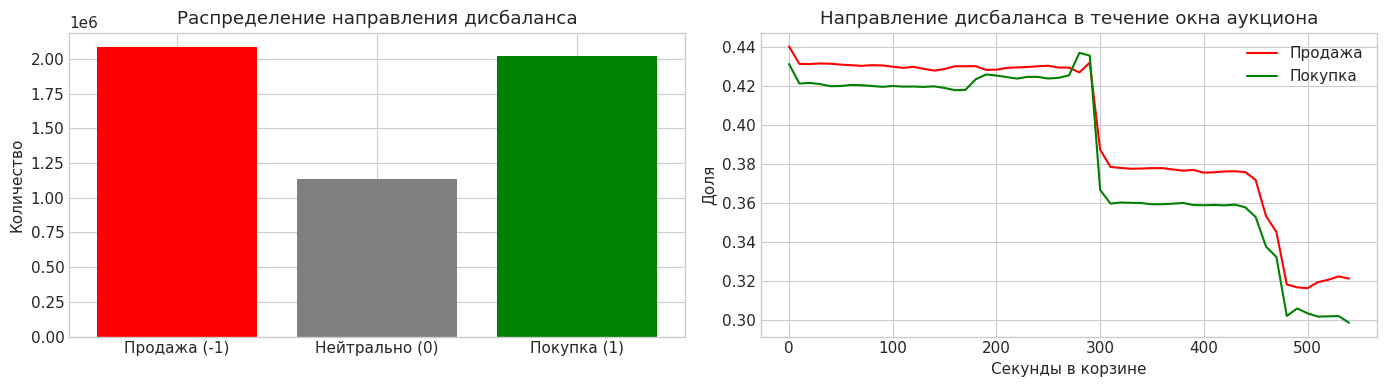

In [109]:
# Распределение направления дисбаланса
imbalance_flags = df['imbalance_buy_sell_flag'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Общее распределение
labels = ['Продажа (-1)', 'Нейтрально (0)', 'Покупка (1)']
colors = ['red', 'gray', 'green']
axes[0].bar(imbalance_flags.index, imbalance_flags.values, color=colors)
axes[0].set_xticks([-1, 0, 1])
axes[0].set_xticklabels(labels)
axes[0].set_ylabel('Количество')
axes[0].set_title('Распределение направления дисбаланса')

# По времени
imbalance_by_time_dir = df.groupby(['seconds_in_bucket', 'imbalance_buy_sell_flag']).size().unstack(fill_value=0)
imbalance_by_time_dir_pct = imbalance_by_time_dir.div(imbalance_by_time_dir.sum(axis=1), axis=0)

for col, color in zip([-1, 1], ['red', 'green']):
    if col in imbalance_by_time_dir_pct.columns:
        axes[1].plot(imbalance_by_time_dir_pct.index, imbalance_by_time_dir_pct[col], 
                    label=f'{"Покупка" if col == 1 else "Продажа"}', color=color)

axes[1].set_xlabel('Секунды в корзине')
axes[1].set_ylabel('Доля')
axes[1].set_title('Направление дисбаланса в течение окна аукциона')
axes[1].legend()

plt.tight_layout()
plt.show()

In [110]:
# Соотношение размера дисбаланса и объёма сопоставленных заявок во времени
df['imbalance_ratio'] = df['imbalance_size'] / (df['matched_size'] + 1)  # +1 чтобы избежать деления на ноль

ratio_by_time = df.groupby('seconds_in_bucket')['imbalance_ratio'].agg(['mean', 'median'])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ratio_by_time.index,
    y=ratio_by_time['mean'],
    mode='lines',
    name='Среднее соотношение'
))

fig.add_trace(go.Scatter(
    x=ratio_by_time.index,
    y=ratio_by_time['median'],
    mode='lines',
    name='Медианное соотношение',
    line=dict(dash='dash')
))

fig.update_layout(
    title='Соотношение дисбаланса к сопоставленному объёму во время аукциона',
    xaxis_title='Секунды в корзине',
    yaxis_title='дисбаланс/сопоставленный объём',
    height=400
)
fig.show()

In [111]:
# Целевая переменная по направлению дисбаланса
target_by_imbalance = df.groupby('imbalance_buy_sell_flag')['target'].agg(['mean', 'median', 'std', 'count'])
print("Статистика целевой переменной по направлению дисбаланса:")
target_by_imbalance

Статистика целевой переменной по направлению дисбаланса:


,mean,median,std,count
imbalance_buy_sell_flag,,,,
-1,-0.2023,-0.1800,9.2312,2084348
0,-0.0627,-0.0501,9.1613,1131507
1,0.1204,0.0596,9.8291,2022037


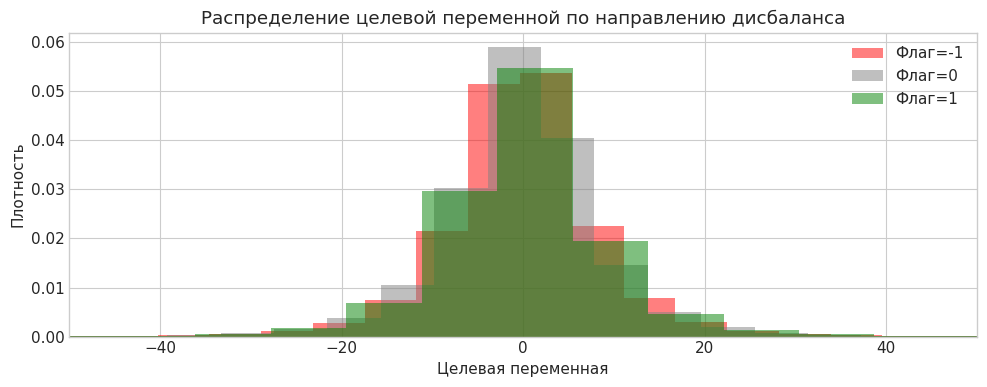

In [112]:

fig, ax = plt.subplots(figsize=(10, 4))

for flag, color in zip([-1, 0, 1], ['red', 'gray', 'green']):
    data = df[df['imbalance_buy_sell_flag'] == flag]['target'].dropna()
    ax.hist(data, bins=100, alpha=0.5, label=f'Флаг={flag}', color=color, density=True)

ax.set_xlabel('Целевая переменная')
ax.set_ylabel('Плотность')
ax.set_title('Распределение целевой переменной по направлению дисбаланса')
ax.legend()
ax.set_xlim(-50, 50)
plt.tight_layout()
plt.show()

### 4.2 Процесс ценообразования

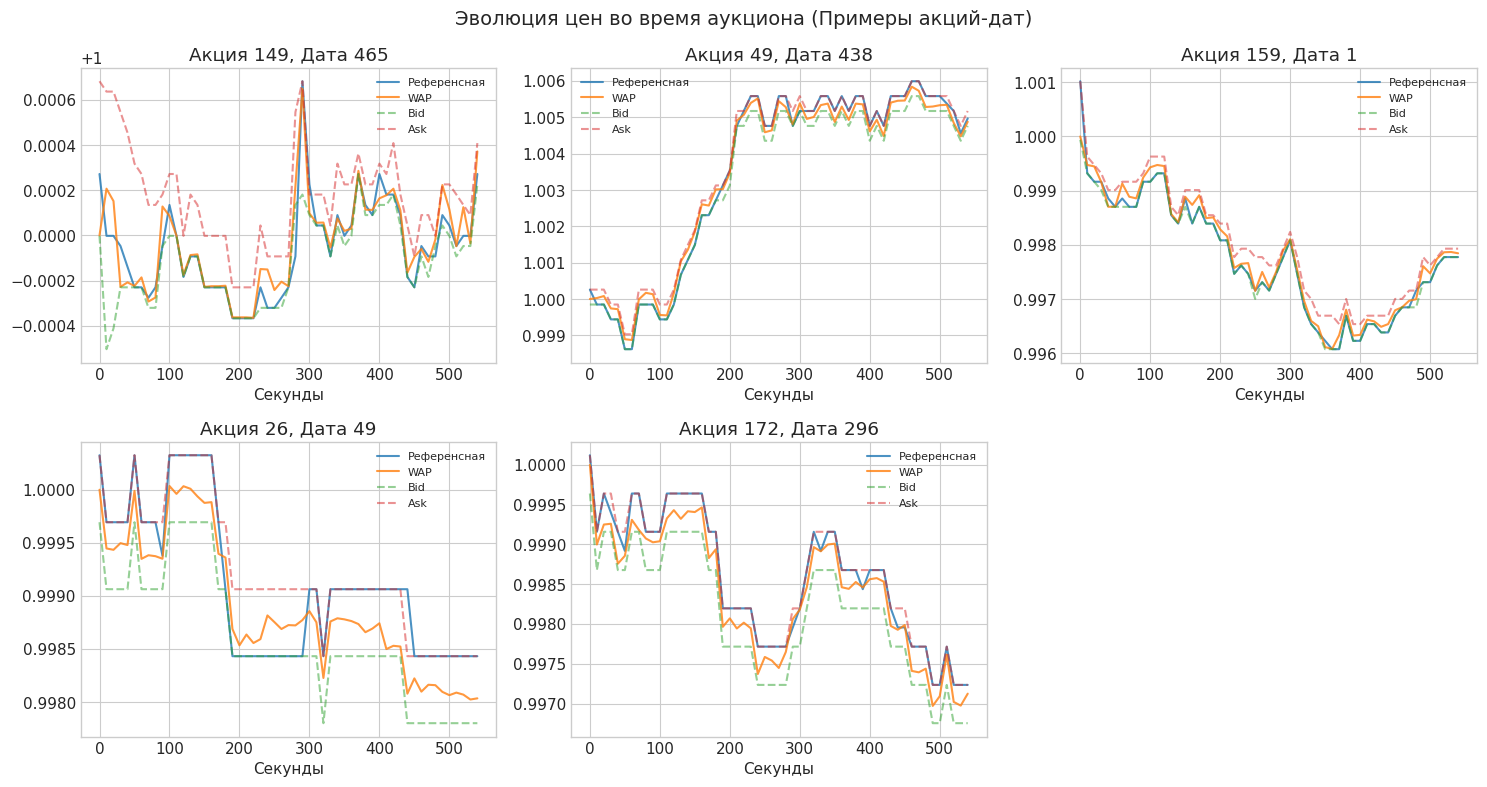

In [113]:
# Движение референсной цены внутри аукциона
# Выборка нескольких комбинаций акция-дата для визуализации
sample_combos = df[['stock_id', 'date_id']].drop_duplicates().sample(5, random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, (_, row) in enumerate(sample_combos.iterrows()):
    if idx >= 5:
        break
    mask = (df['stock_id'] == row['stock_id']) & (df['date_id'] == row['date_id'])
    subset = df[mask].sort_values('seconds_in_bucket')
    
    if len(subset) > 0:
        axes[idx].plot(subset['seconds_in_bucket'], subset['reference_price'], label='Референсная', alpha=0.8)
        axes[idx].plot(subset['seconds_in_bucket'], subset['wap'], label='WAP', alpha=0.8)
        axes[idx].plot(subset['seconds_in_bucket'], subset['bid_price'], label='Bid', alpha=0.5, linestyle='--')
        axes[idx].plot(subset['seconds_in_bucket'], subset['ask_price'], label='Ask', alpha=0.5, linestyle='--')
        axes[idx].set_title(f'Акция {row["stock_id"]}, Дата {row["date_id"]}')
        axes[idx].set_xlabel('Секунды')
        axes[idx].legend(fontsize=8)

# Использовать последний подграфик для легенды
axes[5].axis('off')

plt.suptitle('Эволюция цен во время аукциона (Примеры акций-дат)', fontsize=14)
plt.tight_layout()
plt.show()

In [114]:
# Расхождение WAP и референсной цены
df['wap_ref_diff'] = (df['wap'] - df['reference_price']) / df['reference_price'] * 10000  # базисные пункты

diff_by_time = df.groupby('seconds_in_bucket')['wap_ref_diff'].agg(['mean', 'median', 'std'])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=diff_by_time.index,
    y=diff_by_time['mean'],
    mode='lines',
    name='Средняя разница',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=diff_by_time.index,
    y=diff_by_time['mean'] + diff_by_time['std'],
    mode='lines',
    name='+1 Станд.откл.',
    line=dict(color='lightblue', dash='dash')
))

fig.add_trace(go.Scatter(
    x=diff_by_time.index,
    y=diff_by_time['mean'] - diff_by_time['std'],
    mode='lines',
    name='-1 Станд.откл.',
    line=dict(color='lightblue', dash='dash'),
    fill='tonexty'
))

fig.add_hline(y=0, line_dash='dash', line_color='red')

fig.update_layout(
    title='Расхождение WAP и референсной цены во время аукциона',
    xaxis_title='Секунды в корзине',
    yaxis_title='(WAP - Референсная) / Референсная (б.п.)',
    height=400
)
fig.show()

Доступность цен Far/Near:
Far price: 2,343,638 (44.7%)
Near price: 2,380,800 (45.5%)


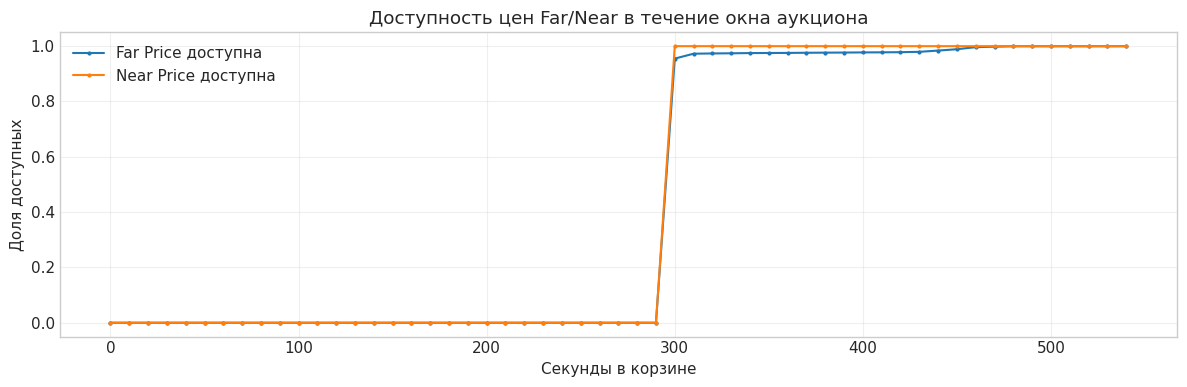

In [115]:
# Анализ цен far/near (когда доступны)
far_near_avail = df[['far_price', 'near_price']].notna().sum()
print("Доступность цен Far/Near:")
print(f"Far price: {far_near_avail['far_price']:,} ({far_near_avail['far_price']/len(df)*100:.1f}%)")
print(f"Near price: {far_near_avail['near_price']:,} ({far_near_avail['near_price']/len(df)*100:.1f}%)")

# Доступность цен far/near по времени
far_avail_by_time = df.groupby('seconds_in_bucket')['far_price'].apply(lambda x: x.notna().mean())
near_avail_by_time = df.groupby('seconds_in_bucket')['near_price'].apply(lambda x: x.notna().mean())

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(far_avail_by_time.index, far_avail_by_time.values, label='Far Price доступна', marker='o', markersize=2)
ax.plot(near_avail_by_time.index, near_avail_by_time.values, label='Near Price доступна', marker='o', markersize=2)
ax.set_xlabel('Секунды в корзине')
ax.set_ylabel('Доля доступных')
ax.set_title('Доступность цен Far/Near в течение окна аукциона')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.3 Паттерны ликвидности

In [116]:
# Эволюция размера Bid/Ask
bid_ask_by_time = df.groupby('seconds_in_bucket')[['bid_size', 'ask_size']].mean()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=bid_ask_by_time.index,
    y=bid_ask_by_time['bid_size'],
    mode='lines',
    name='Размер Bid',
    line=dict(color='green')
))

fig.add_trace(go.Scatter(
    x=bid_ask_by_time.index,
    y=bid_ask_by_time['ask_size'],
    mode='lines',
    name='Размер Ask',
    line=dict(color='red')
))

fig.update_layout(
    title='Эволюция размера Bid/Ask во время аукциона',
    xaxis_title='Секунды в корзине',
    yaxis_title='Размер ($)',
    height=400
)
fig.show()

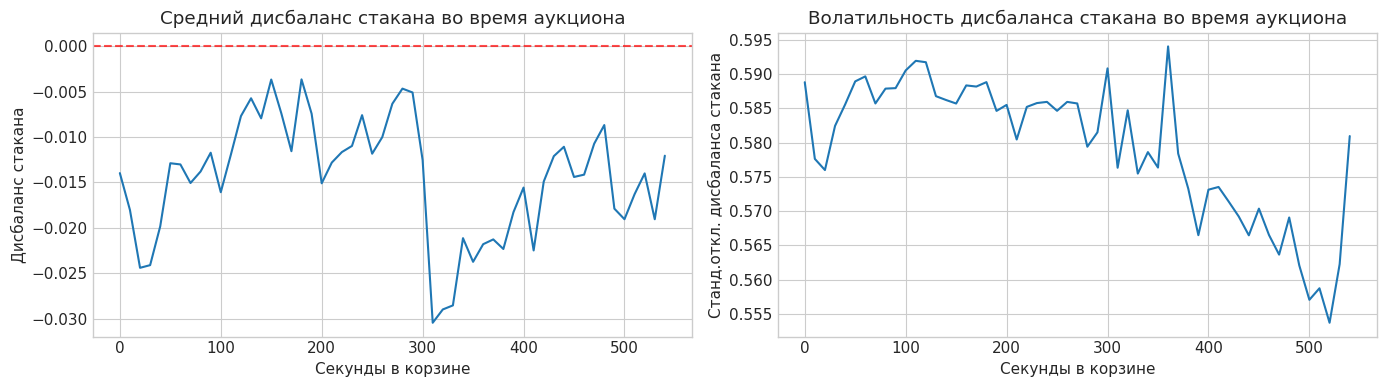

In [117]:
# Дисбаланс стакана (bid_size - ask_size) / (bid_size + ask_size)
df['book_imbalance'] = (df['bid_size'] - df['ask_size']) / (df['bid_size'] + df['ask_size'] + 1)

book_imb_by_time = df.groupby('seconds_in_bucket')['book_imbalance'].agg(['mean', 'std'])

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(book_imb_by_time.index, book_imb_by_time['mean'])
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
axes[0].set_xlabel('Секунды в корзине')
axes[0].set_ylabel('Дисбаланс стакана')
axes[0].set_title('Средний дисбаланс стакана во время аукциона')

axes[1].plot(book_imb_by_time.index, book_imb_by_time['std'])
axes[1].set_xlabel('Секунды в корзине')
axes[1].set_ylabel('Станд.откл. дисбаланса стакана')
axes[1].set_title('Волатильность дисбаланса стакана во время аукциона')

plt.tight_layout()
plt.show()

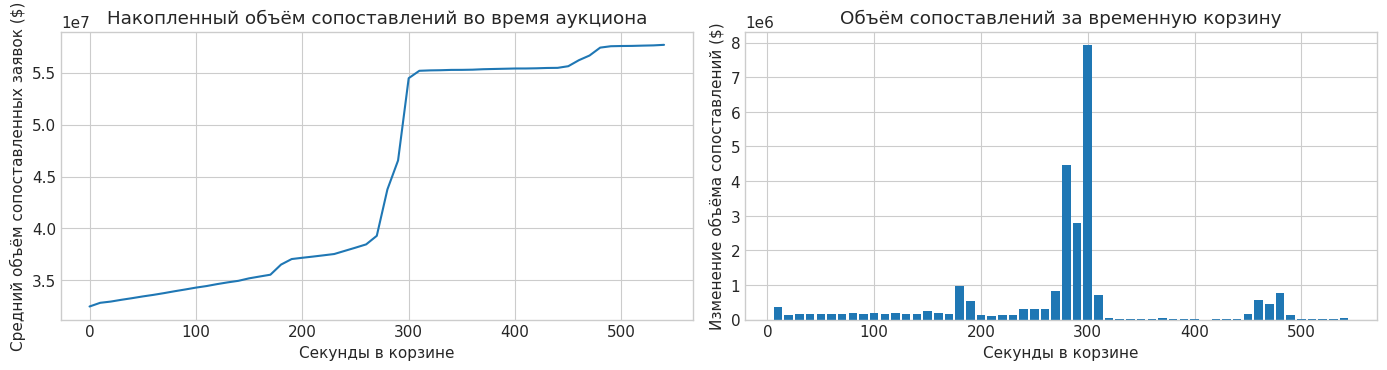

In [118]:
# Концентрация объёма: когда происходит большая часть сопоставлений?
# Расчёт изменения matched_size
matched_growth = df.groupby('seconds_in_bucket')['matched_size'].mean()
matched_growth_diff = matched_growth.diff()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(matched_growth.index, matched_growth.values)
axes[0].set_xlabel('Секунды в корзине')
axes[0].set_ylabel('Средний объём сопоставленных заявок ($)')
axes[0].set_title('Накопленный объём сопоставлений во время аукциона')

axes[1].bar(matched_growth_diff.index, matched_growth_diff.values, width=8)
axes[1].set_xlabel('Секунды в корзине')
axes[1].set_ylabel('Изменение объёма сопоставлений ($)')
axes[1].set_title('Объём сопоставлений за временную корзину')

plt.tight_layout()
plt.show()

---
## 5. Временные паттерны между датами

### 5.1 Тренды на уровне дат

In [119]:
# Наблюдений на дату
obs_per_date = df.groupby('date_id').size()

fig = px.line(
    x=obs_per_date.index,
    y=obs_per_date.values,
    labels={'x': 'ID даты', 'y': 'Количество наблюдений'},
    title='Количество наблюдений по датам'
)
fig.update_layout(height=400)
fig.show()

print(f"\nДиапазон дат: {obs_per_date.index.min()} до {obs_per_date.index.max()}")
print(f"Среднее наблюдений на дату: {obs_per_date.mean():,.0f}")
print(f"Станд.откл.: {obs_per_date.std():,.0f}")


Диапазон дат: 0 до 480
Среднее наблюдений на дату: 10,890
Станд.откл.: 134


In [120]:
# Статистика целевой переменной по датам
target_by_date = df.groupby('date_id')['target'].agg(['mean', 'median', 'std'])

fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=['Среднее целевой по датам', 'Медиана целевой по датам', 'Станд.откл. целевой по датам'],
    shared_xaxes=True
)

fig.add_trace(
    go.Scatter(x=target_by_date.index, y=target_by_date['mean'], mode='lines', name='Среднее'),
    row=1, col=1
)
fig.add_hline(y=0, line_dash='dash', line_color='red', row=1, col=1)

fig.add_trace(
    go.Scatter(x=target_by_date.index, y=target_by_date['median'], mode='lines', name='Медиана', line=dict(color='green')),
    row=2, col=1
)
fig.add_hline(y=0, line_dash='dash', line_color='red', row=2, col=1)

fig.add_trace(
    go.Scatter(x=target_by_date.index, y=target_by_date['std'], mode='lines', name='Станд.откл.', line=dict(color='orange')),
    row=3, col=1
)

fig.update_layout(height=600, title_text='Статистика целевой переменной во времени', showlegend=False)
fig.update_xaxes(title_text='ID даты', row=3, col=1)
fig.show()

In [121]:
# Тренды статистики признаков по датам
key_features = ['imbalance_size', 'matched_size', 'spread_pct']
feature_by_date = df.groupby('date_id')[key_features].mean()

fig = make_subplots(
    rows=len(key_features), cols=1,
    subplot_titles=[f'{f} (Среднее по датам)' for f in key_features],
    shared_xaxes=True
)

for i, feat in enumerate(key_features):
    fig.add_trace(
        go.Scatter(x=feature_by_date.index, y=feature_by_date[feat], mode='lines', name=feat),
        row=i+1, col=1
    )

fig.update_layout(height=500, title_text='Ключевые признаки во времени', showlegend=False)
fig.update_xaxes(title_text='ID даты', row=len(key_features), col=1)
fig.show()

### 5.2 Изменчивость между днями

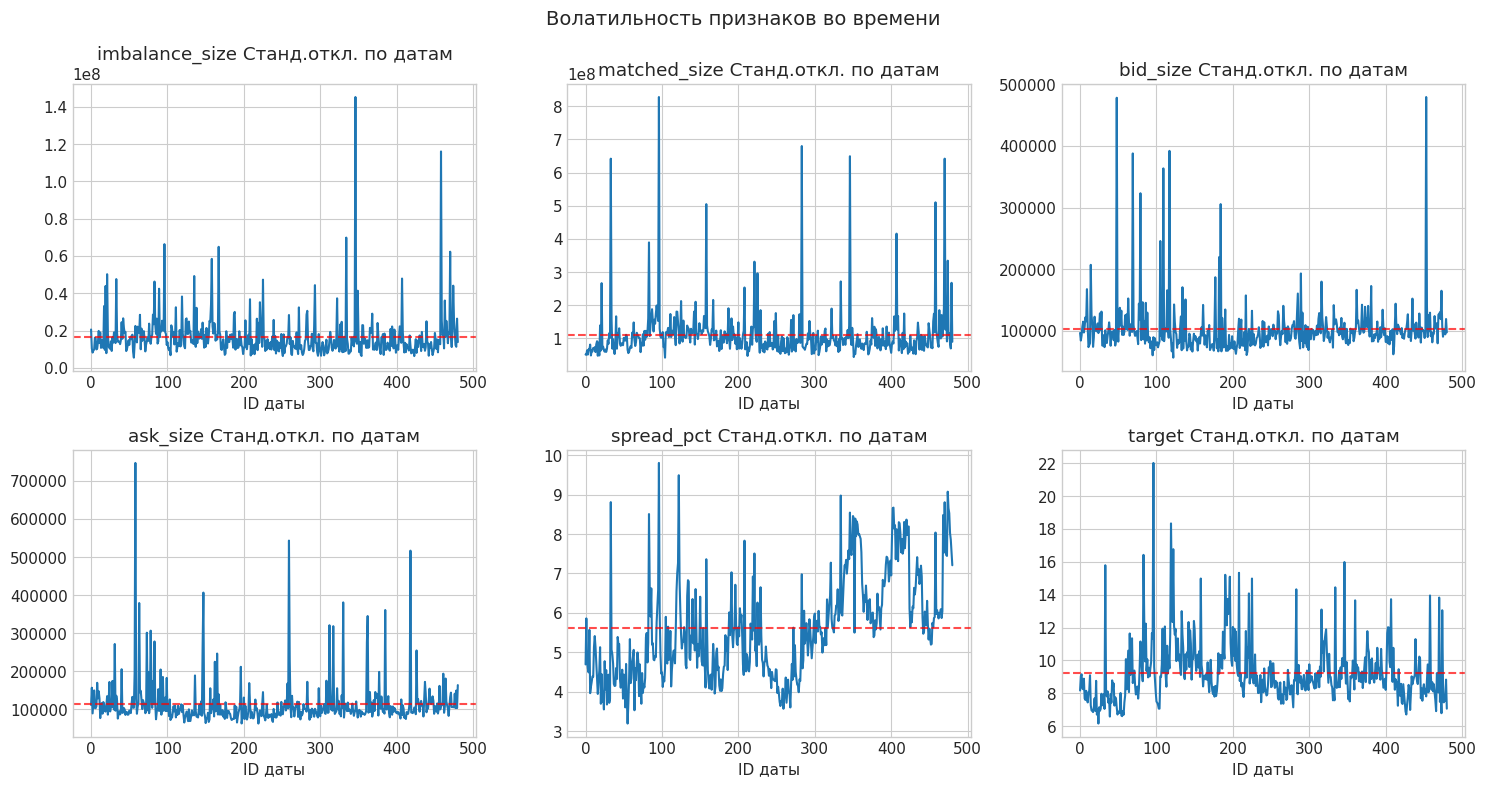

In [122]:
# Волатильность признаков по датам
features_for_vol = ['imbalance_size', 'matched_size', 'bid_size', 'ask_size', 'spread_pct', 'target']
vol_by_date = df.groupby('date_id')[features_for_vol].std()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feat in enumerate(features_for_vol):
    axes[i].plot(vol_by_date.index, vol_by_date[feat])
    axes[i].set_title(f'{feat} Станд.откл. по датам')
    axes[i].set_xlabel('ID даты')
    axes[i].axhline(y=vol_by_date[feat].mean(), color='r', linestyle='--', alpha=0.7)

plt.suptitle('Волатильность признаков во времени', fontsize=14)
plt.tight_layout()
plt.show()

In [123]:
# Определение аномальных дат
target_vol_by_date = df.groupby('date_id')['target'].std()
threshold = target_vol_by_date.mean() + 2 * target_vol_by_date.std()

high_vol_dates = target_vol_by_date[target_vol_by_date > threshold]

print(f"Даты с высокой волатильностью (станд.откл. целевой >{threshold:.2f}):")
high_vol_dates.sort_values(ascending=False).head(10)


Даты с высокой волатильностью (станд.откл. целевой >12.98):


date_id
96    22.0169
119   18.3358
122   16.7667
83    16.4224
346   15.9856
33    15.7904
208   15.3284
190   15.2081
196   15.0919
158   14.9817
Name: target, dtype: float32

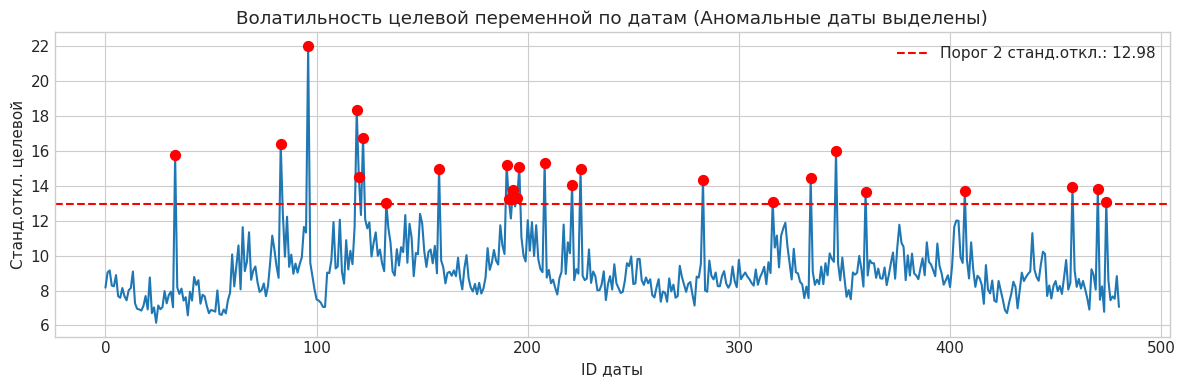

In [124]:

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(target_vol_by_date.index, target_vol_by_date.values)
ax.axhline(y=threshold, color='r', linestyle='--', label=f'Порог 2 станд.откл.: {threshold:.2f}')
ax.scatter(high_vol_dates.index, high_vol_dates.values, color='red', s=50, zorder=5)
ax.set_xlabel('ID даты')
ax.set_ylabel('Станд.откл. целевой')
ax.set_title('Волатильность целевой переменной по датам (Аномальные даты выделены)')
ax.legend()
plt.tight_layout()
plt.show()

---
## 6. Временное поведение акций

### 6.1 Временные паттерны на уровне акций

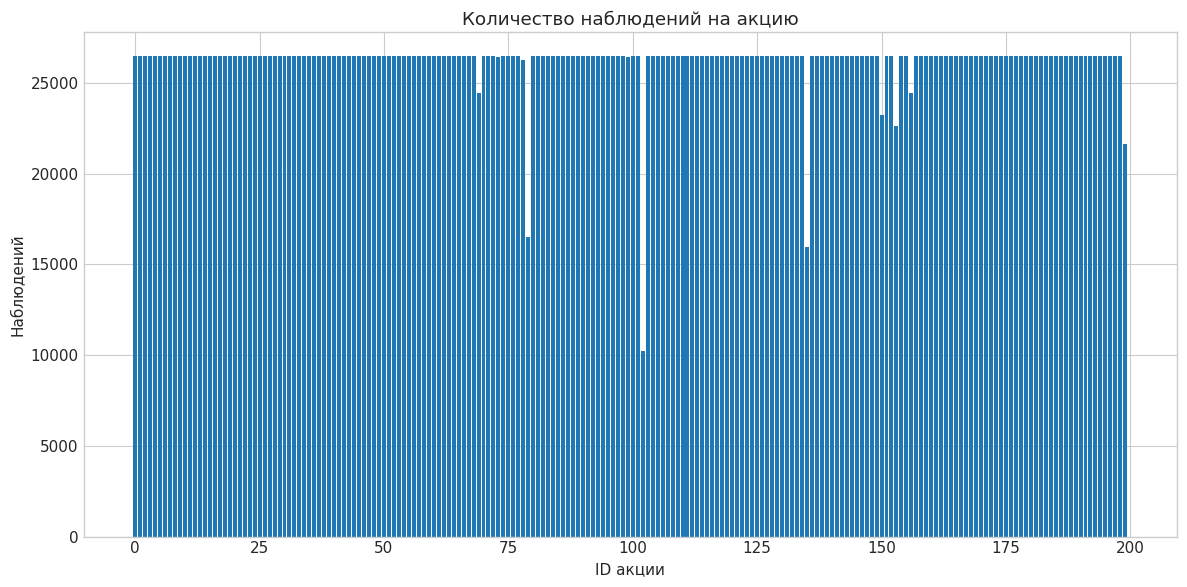


Количество акций: 200
Среднее наблюдений на акцию: 26,190
Станд.откл.: 1,610


In [125]:
# Наблюдений на акцию
obs_per_stock = df.groupby('stock_id').size()

plt.bar(obs_per_stock.index, obs_per_stock.values)
plt.xlabel('ID акции')
plt.ylabel('Наблюдений')
plt.title('Количество наблюдений на акцию')


plt.tight_layout()
plt.show()

print(f"\nКоличество акций: {len(obs_per_stock)}")
print(f"Среднее наблюдений на акцию: {obs_per_stock.mean():,.0f}")
print(f"Станд.откл.: {obs_per_stock.std():,.0f}")

In [126]:
# Статистика целевой переменной по акциям
target_by_stock = df.groupby('stock_id')['target'].agg(['mean', 'median', 'std'])

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=['Среднее целевой по акциям', 'Медиана целевой по акциям', 'Станд.откл. целевой по акциям']
)

fig.add_trace(
    go.Bar(x=target_by_stock.index, y=target_by_stock['mean'], name='Среднее'),
    row=1, col=1
)
fig.add_hline(y=0, line_dash='dash', line_color='red', row=1, col=1)

fig.add_trace(
    go.Bar(x=target_by_stock.index, y=target_by_stock['median'], name='Медиана'),
    row=1, col=2
)
fig.add_hline(y=0, line_dash='dash', line_color='red', row=1, col=2)

fig.add_trace(
    go.Bar(x=target_by_stock.index, y=target_by_stock['std'], name='Станд.откл.'),
    row=1, col=3
)

fig.update_layout(height=400, title_text='Статистика целевой переменной по акциям', showlegend=False)
fig.show()

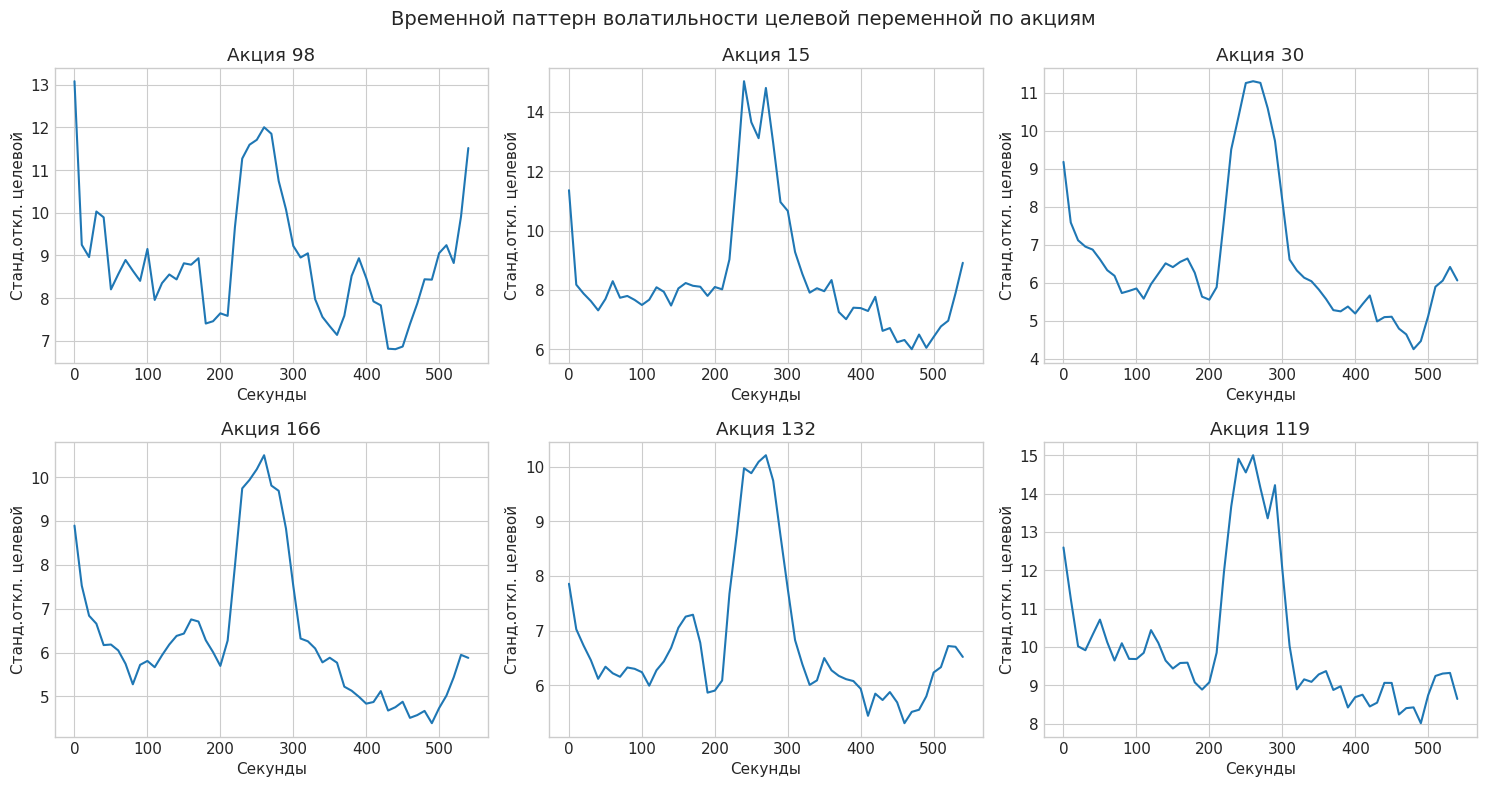

In [127]:
# Одинаковая ли временная структура у всех акций?
# Сравнение динамики аукциона для разных акций
sample_stocks = df['stock_id'].drop_duplicates().sample(6, random_state=42).tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, stock in enumerate(sample_stocks):
    stock_data = df[df['stock_id'] == stock]
    target_by_time_stock = stock_data.groupby('seconds_in_bucket')['target'].std()
    axes[i].plot(target_by_time_stock.index, target_by_time_stock.values)
    axes[i].set_title(f'Акция {stock}')
    axes[i].set_xlabel('Секунды')
    axes[i].set_ylabel('Станд.откл. целевой')

plt.suptitle('Временной паттерн волатильности целевой переменной по акциям', fontsize=14)
plt.tight_layout()
plt.show()

### 6.2 Межакционные корреляции во времени

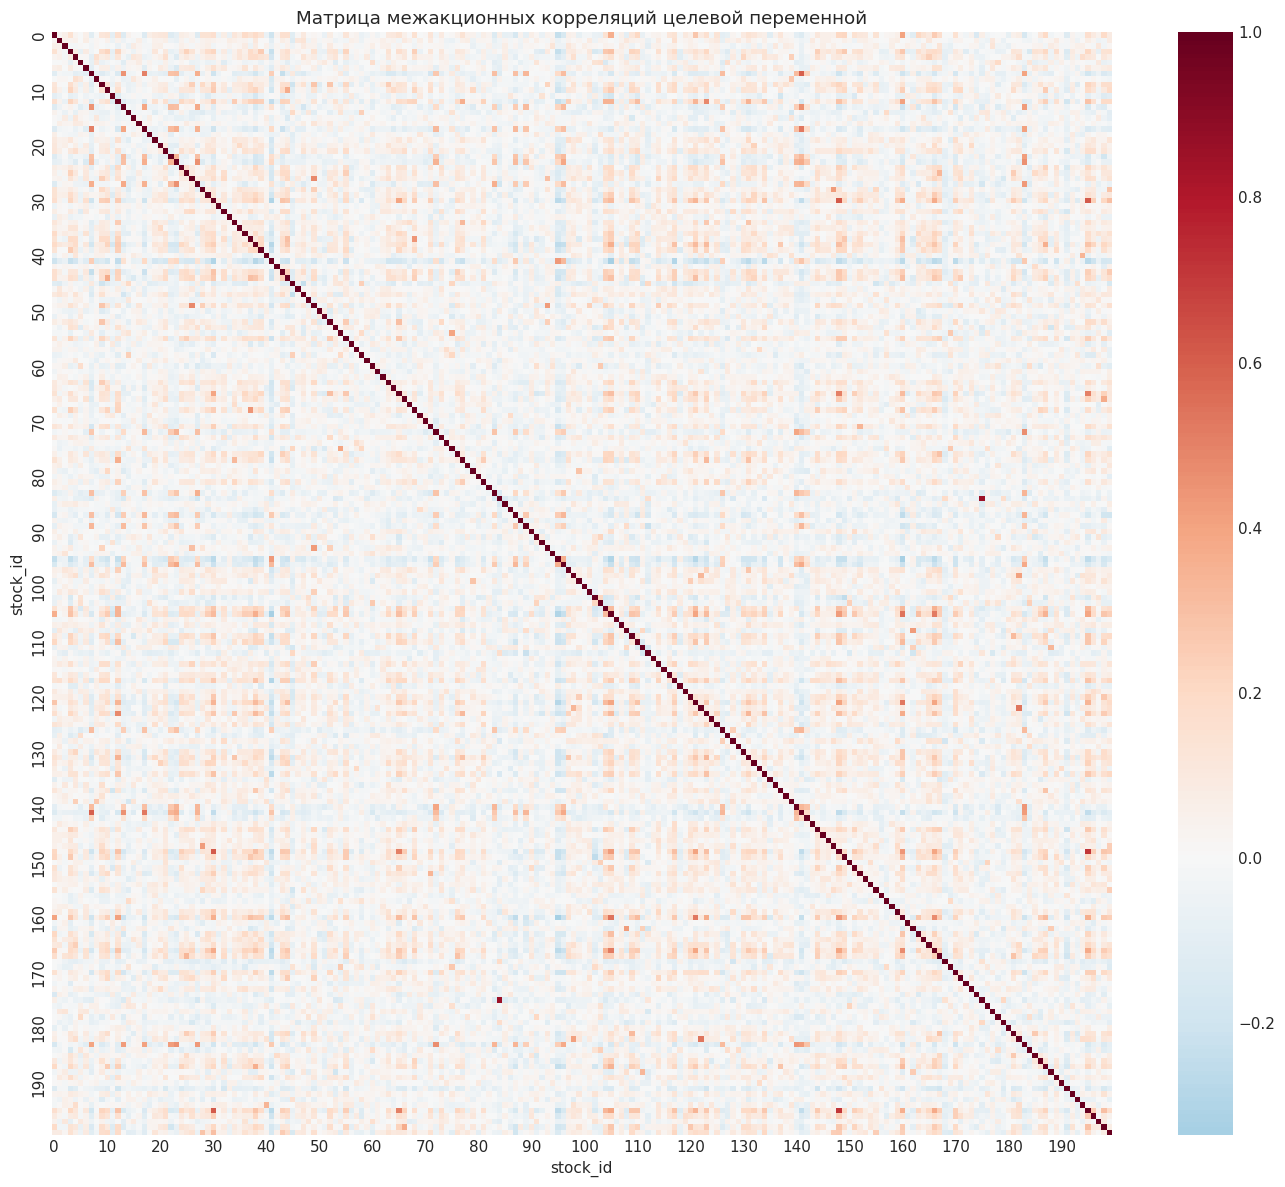


Статистика межакционных корреляций:
Среднее: 0.0155
Медиана: 0.0078
Станд.откл.: 0.0858
Минимум: -0.3358
Максимум: 0.8573


In [128]:
# Выборка подмножества time_id для анализа корреляций
sample_time_ids = df['time_id'].drop_duplicates().sample(min(1000, df['time_id'].nunique()), random_state=42)

# Сводная таблица с акциями в столбцах для расчёта корреляций
sample_df = df[df['time_id'].isin(sample_time_ids)][['time_id', 'stock_id', 'target']]
pivot_df = sample_df.pivot_table(index='time_id', columns='stock_id', values='target')

# Расчёт корреляционной матрицы
stock_corr = pivot_df.corr()

# Тепловая карта
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(stock_corr, cmap='RdBu_r', center=0, ax=ax, 
            xticklabels=10, yticklabels=10)
ax.set_title('Матрица межакционных корреляций целевой переменной')
plt.tight_layout()
plt.show()

# Сводная статистика
upper_tri = stock_corr.where(np.triu(np.ones(stock_corr.shape), k=1).astype(bool))
correlations = upper_tri.stack()

print(f"\nСтатистика межакционных корреляций:")
print(f"Среднее: {correlations.mean():.4f}")
print(f"Медиана: {correlations.median():.4f}")
print(f"Станд.откл.: {correlations.std():.4f}")
print(f"Минимум: {correlations.min():.4f}")
print(f"Максимум: {correlations.max():.4f}")

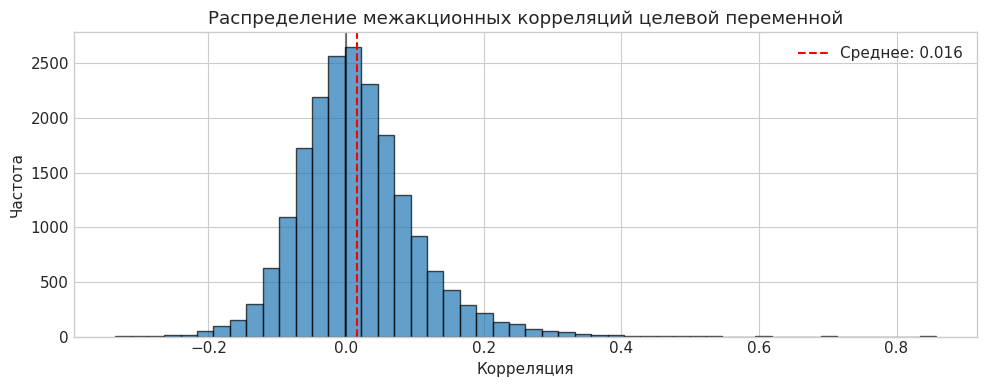

In [129]:
# Распределение межакционных корреляций
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(correlations, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(x=correlations.mean(), color='r', linestyle='--', label=f'Среднее: {correlations.mean():.3f}')
ax.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax.set_xlabel('Корреляция')
ax.set_ylabel('Частота')
ax.set_title('Распределение межакционных корреляций целевой переменной')
ax.legend()
plt.tight_layout()
plt.show()

---
## 7. Взаимосвязи признаков с целевой переменной

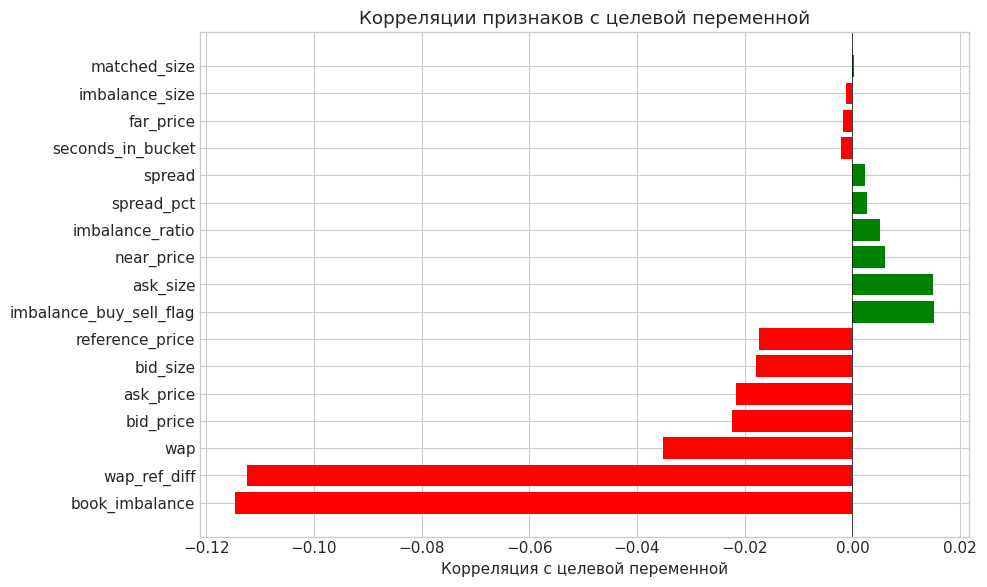

In [130]:
# Корреляция с целевой переменной
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['row_id', 'time_id', 'stock_id', 'date_id']]

target_corr = df[numeric_cols].corr()['target'].drop('target').sort_values(key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in target_corr.values]
ax.barh(target_corr.index, target_corr.values, color=colors)
ax.set_xlabel('Корреляция с целевой переменной')
ax.set_title('Корреляции признаков с целевой переменной')
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

In [131]:

print("\nТоп корреляций с целевой переменной:")
target_corr


Топ корреляций с целевой переменной:


book_imbalance            -0.1146
wap_ref_diff              -0.1124
wap                       -0.0352
bid_price                 -0.0223
ask_price                 -0.0217
bid_size                  -0.0180
reference_price           -0.0174
imbalance_buy_sell_flag    0.0151
ask_size                   0.0149
near_price                 0.0060
imbalance_ratio            0.0051
spread_pct                 0.0026
spread                     0.0024
seconds_in_bucket         -0.0022
far_price                 -0.0018
imbalance_size            -0.0012
matched_size               0.0002
Name: target, dtype: float64

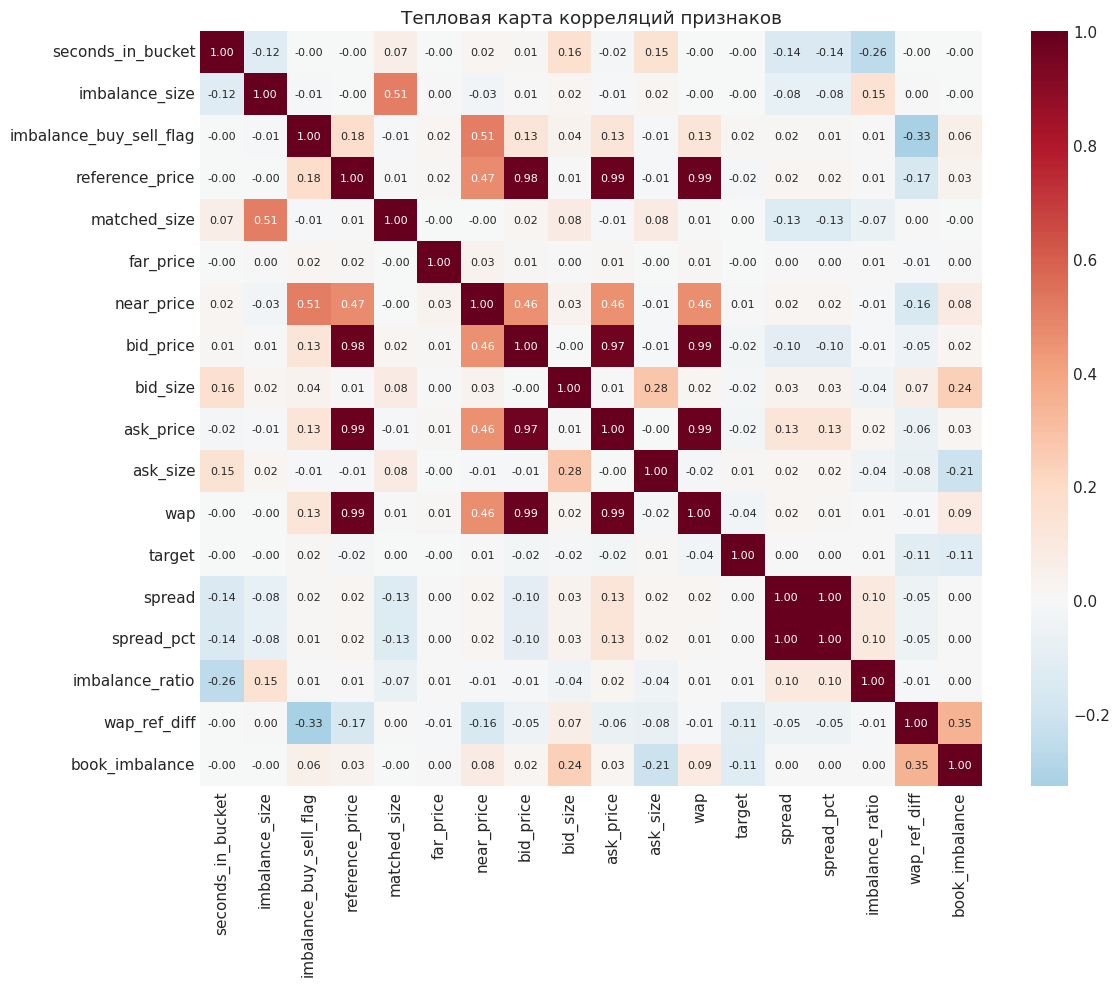

In [132]:
# Полная корреляционная тепловая карта
corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax,
            annot_kws={'size': 8})
ax.set_title('Тепловая карта корреляций признаков')
plt.tight_layout()
plt.show()

In [133]:
# Корреляции, зависящие от времени (начало vs конец аукциона)
early_auction = df[df['seconds_in_bucket'] <= 180]  # Первые 3 минуты
late_auction = df[df['seconds_in_bucket'] > 300]   # Последние 4 минуты

early_corr = early_auction[numeric_cols].corr()['target'].drop('target')
late_corr = late_auction[numeric_cols].corr()['target'].drop('target')

comparison = pd.DataFrame({
    'Начало аукциона (0-180с)': early_corr,
    'Конец аукциона (300-540с)': late_corr,
    'Разница': late_corr - early_corr
}).sort_values('Разница', key=abs, ascending=False)

print("Корреляции с целевой переменной, зависящие от времени:")
comparison

Корреляции с целевой переменной, зависящие от времени:


,Начало аукциона (0-180с),Конец аукциона (300-540с),Разница
reference_price,0.0114,-0.0431,-0.0546
ask_price,0.0027,-0.0472,-0.0500
bid_price,0.0009,-0.0468,-0.0477
book_imbalance,-0.1412,-0.0994,0.0418
wap_ref_diff,-0.1440,-0.1034,0.0405
wap,-0.0276,-0.0546,-0.0270
ask_size,0.0247,0.0120,-0.0127
imbalance_ratio,0.0011,0.0101,0.0090
spread,0.0045,-0.0035,-0.0081
spread_pct,0.0047,-0.0032,-0.0079


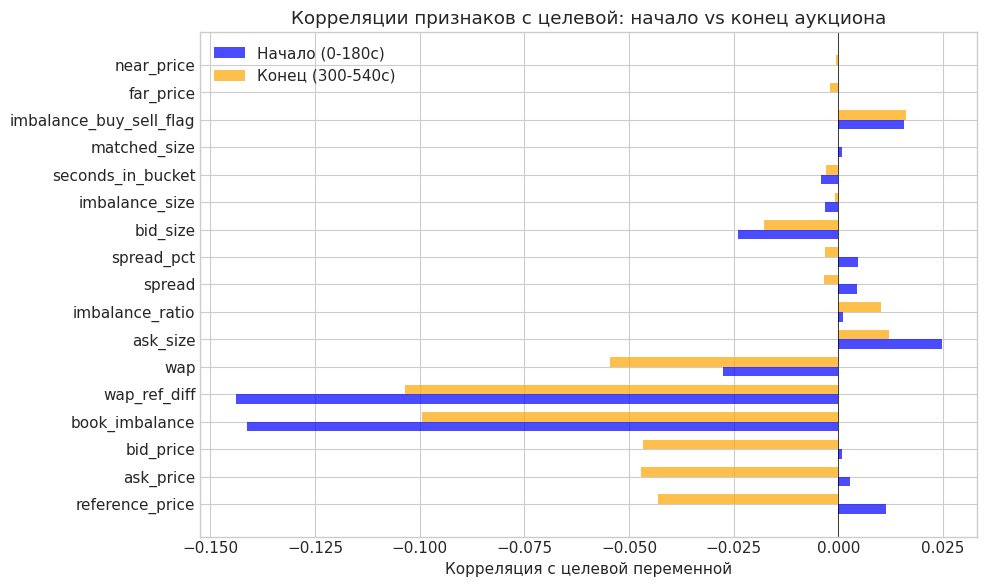

In [134]:
# Визуализация корреляций, зависящих от времени
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison))
width = 0.35

ax.barh(x - width/2, comparison['Начало аукциона (0-180с)'], width, label='Начало (0-180с)', color='blue', alpha=0.7)
ax.barh(x + width/2, comparison['Конец аукциона (300-540с)'], width, label='Конец (300-540с)', color='orange', alpha=0.7)

ax.set_yticks(x)
ax.set_yticklabels(comparison.index)
ax.set_xlabel('Корреляция с целевой переменной')
ax.set_title('Корреляции признаков с целевой: начало vs конец аукциона')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.legend()

plt.tight_layout()
plt.show()

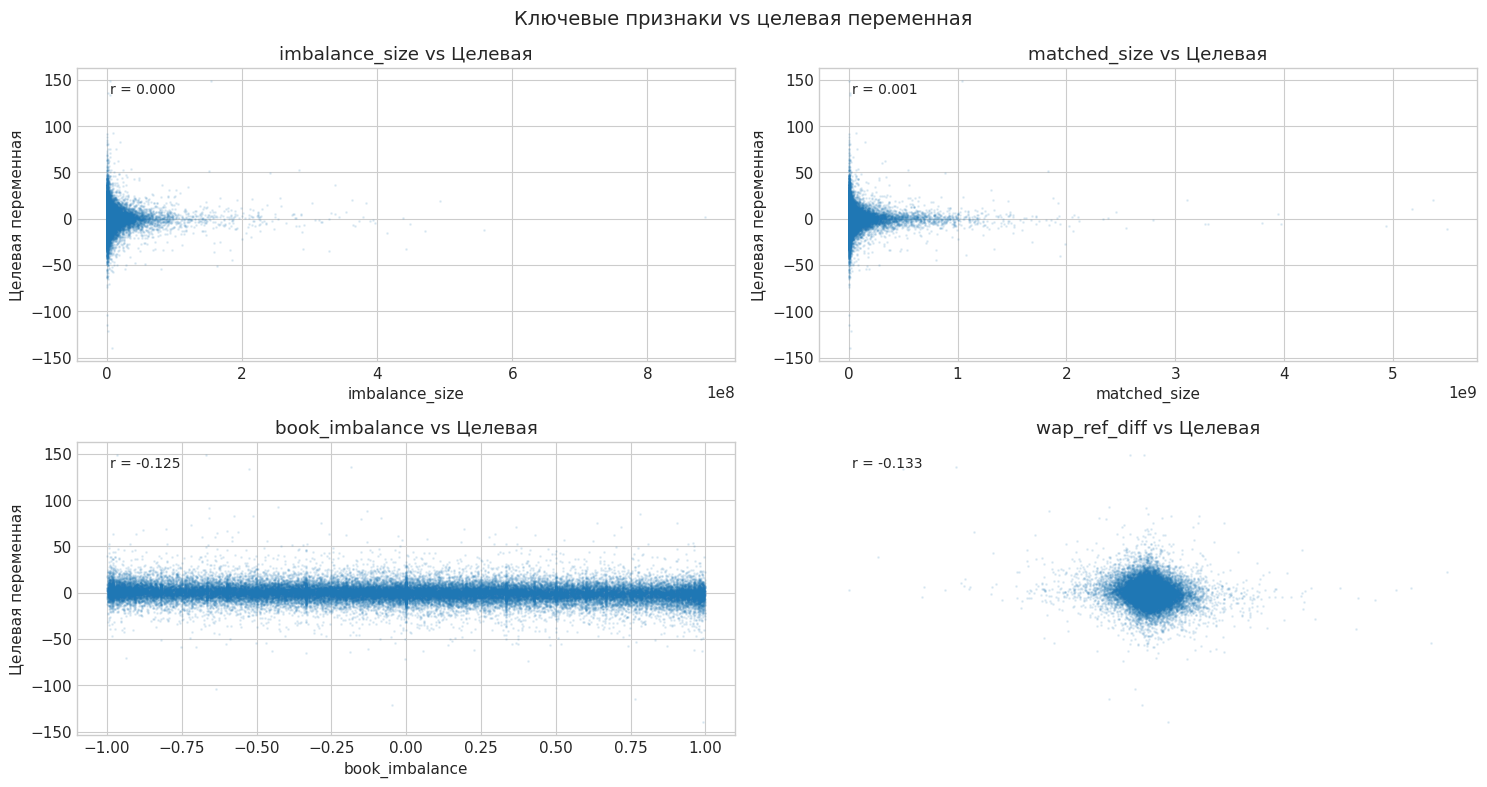

In [135]:
# Диаграммы рассеяния ключевых признаков vs целевая переменная (выборка для производительности)
sample = df.sample(min(50000, len(df)), random_state=42)
key_features_scatter = ['imbalance_size', 'matched_size', 'book_imbalance', 'wap_ref_diff']

fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

for i, feat in enumerate(key_features_scatter):
    if feat in sample.columns:
        axes[i].scatter(sample[feat], sample['target'], alpha=0.1, s=1)
        axes[i].set_xlabel(feat)
        axes[i].set_ylabel('Целевая переменная')
        axes[i].set_title(f'{feat} vs Целевая')
        # Добавить значение корреляции
        corr = sample[[feat, 'target']].corr().iloc[0, 1]
        axes[i].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[i].transAxes, 
                    fontsize=10, verticalalignment='top')

axes[-1].axis('off')
plt.suptitle('Ключевые признаки vs целевая переменная', fontsize=14)
plt.tight_layout()
plt.show()

### 7.1 Анализ преобразований и генерация признаков

Анализ необходимости преобразований признаков и идеи для feature engineering.

In [136]:
transform_features = ['imbalance_size', 'matched_size', 'bid_size', 'ask_size', 'target']

skewness_results = []
for feat in transform_features:
    if feat in df.columns:
        data = df[feat].dropna()
        skew_val = data.skew()
        kurt_val = data.kurtosis()
        
        # Расчёт skewness после log-преобразования (для положительных значений)
        if data.min() > 0:
            log_skew = np.log1p(data).skew()
        else:
            log_skew = np.nan
            
        skewness_results.append({
            'Признак': feat,
            'Асимметрия': skew_val,
            'Эксцесс': kurt_val,
            'Асимметрия (log1p)': log_skew,
            'Нужен log?': 'Да' if abs(skew_val) > 1 and not np.isnan(log_skew) and abs(log_skew) < abs(skew_val) else 'Нет'
        })

skew_df = pd.DataFrame(skewness_results)
print("\nАнализ асимметрии:")
skew_df


Анализ асимметрии:


,Признак,Асимметрия,Эксцесс,Асимметрия (log1p),Нужен log?
0,imbalance_size,23.9948,1746.9907,NaN,Нет
1,matched_size,14.8090,433.7253,0.1778,Да
2,bid_size,49.1936,9024.3770,NaN,Нет
3,ask_size,87.6526,23649.9961,NaN,Нет
4,target,0.2047,22.5580,NaN,Нет


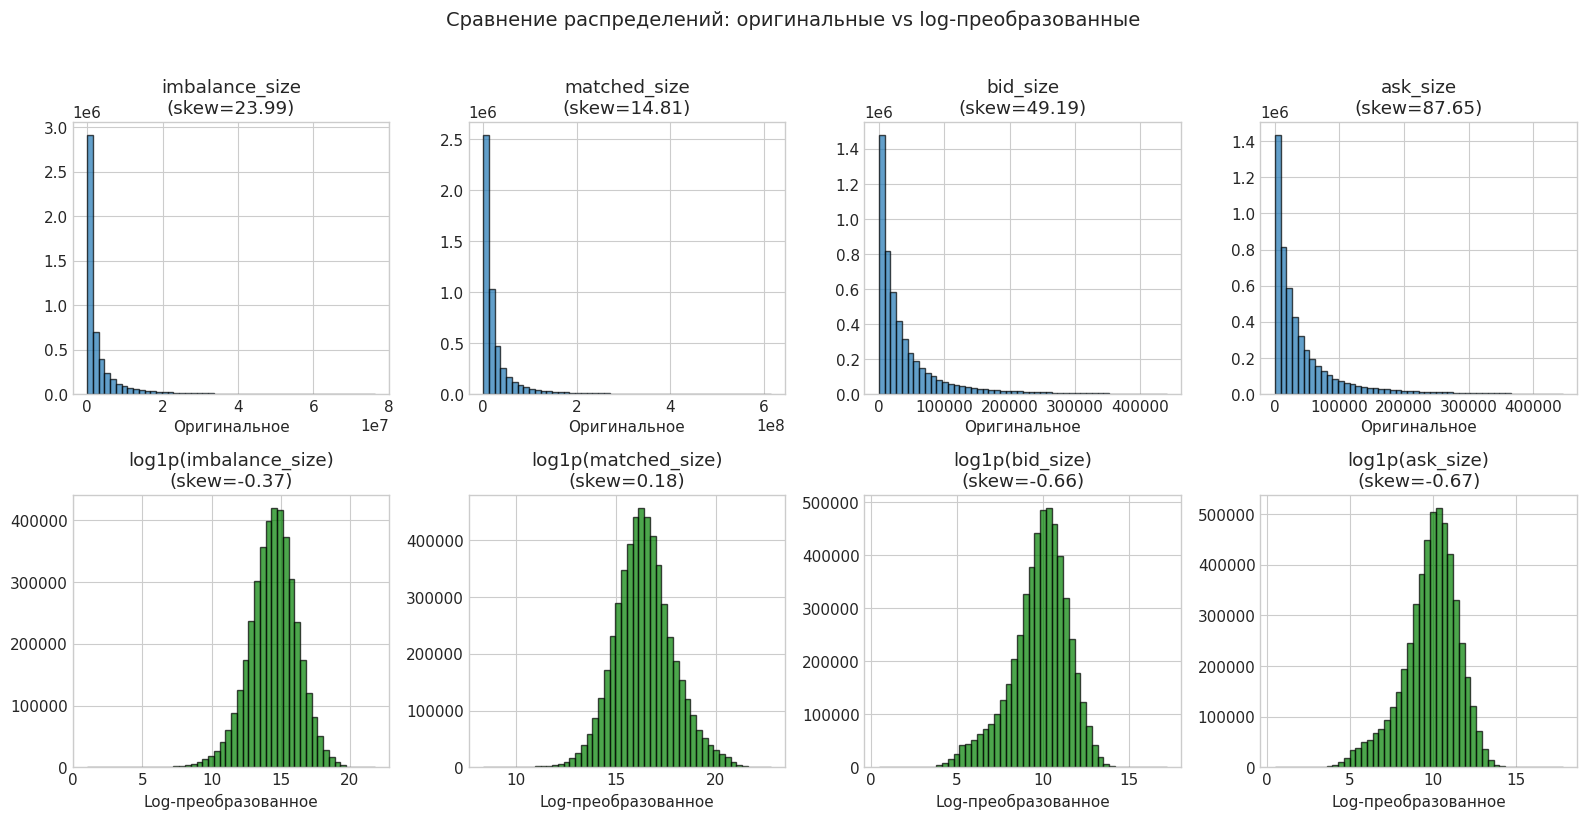


Демонстрация генерации признаков:

Корреляции новых признаков с целевой переменной:
  log_imbalance_size: 0.0059
  log_matched_size: -0.0066
  normalized_time: -0.0001
  is_early_auction: -0.0008
  is_far_available: 0.0023


In [137]:
# Визуализация: сравнение распределений до и после log-преобразования
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

size_feats = ['imbalance_size', 'matched_size', 'bid_size', 'ask_size']
for i, feat in enumerate(size_feats):
    if feat in df.columns:
        data = df[feat].dropna()
        data_pos = data[data > 0]  # Только положительные для log
        
        # Оригинальное распределение (с клиппингом для визуализации)
        q99 = data.quantile(0.99)
        axes[0, i].hist(data[data <= q99], bins=50, edgecolor='black', alpha=0.7)
        axes[0, i].set_title(f'{feat}\n(skew={data.skew():.2f})')
        axes[0, i].set_xlabel('Оригинальное')
        
        # Log-преобразованное распределение
        if len(data_pos) > 0:
            log_data = np.log1p(data_pos)
            axes[1, i].hist(log_data, bins=50, edgecolor='black', alpha=0.7, color='green')
            axes[1, i].set_title(f'log1p({feat})\n(skew={log_data.skew():.2f})')
            axes[1, i].set_xlabel('Log-преобразованное')

plt.suptitle('Сравнение распределений: оригинальные vs log-преобразованные', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Демонстрация некоторых новых признаков
print("\nДемонстрация генерации признаков:")
df_demo = df.sample(100000, random_state=42).copy()

# Создание примеров новых признаков
df_demo['log_imbalance_size'] = np.log1p(df_demo['imbalance_size'])
df_demo['log_matched_size'] = np.log1p(df_demo['matched_size'])
df_demo['normalized_time'] = df_demo['seconds_in_bucket'] / 540
df_demo['is_early_auction'] = (df_demo['seconds_in_bucket'] <= 180).astype(int)
df_demo['is_far_available'] = df_demo['far_price'].notna().astype(int)

# Корреляции новых признаков с целевой
new_features = ['log_imbalance_size', 'log_matched_size', 'normalized_time', 
                'is_early_auction', 'is_far_available']
new_corrs = df_demo[new_features + ['target']].corr()['target'].drop('target')
print("\nКорреляции новых признаков с целевой переменной:")
for feat, corr in new_corrs.items():
    print(f"  {feat}: {corr:.4f}")